In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import gym
from google.colab import widgets
from gym import spaces

In [2]:
# Defining Macros for the environment

GRID_DIM              =   6
MAX_TIMESTEP          =  20
OUT_OF_BOUNDS_PENALTY = -10
GOAL_REWARD           = +60

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def get_state(x, y, grid_size):
  state = x * grid_size + y
  return state  # gives index of state based on grid position ( indexed from 0 to (size*size -1))

In [4]:
class GridEnvironment(gym.Env):
    metadata = {"render_fps": 4}

    def __init__(self, MAX_TIMESTEP):
        self.grid_dim = GRID_DIM
        self.observation_space = spaces.Discrete(self.grid_dim * self.grid_dim)

        self.action_space = spaces.Discrete(4)
        self.max_timesteps = MAX_TIMESTEP

        self.agent_origin_pos = (0, 0)
        self.goal_x = GRID_DIM - 1
        self.goal_y = GRID_DIM - 1
        self.goal_pos = (self.goal_x, self.goal_y)
        self.reward_map_initial = self.init_reward_map()

        #print("Goal position set to:", self.goal_pos)

        self.agent_pos = None
        self.timestep = 0
        self.reward_map = None
        self.state = None

    def init_reward_map(self):

      grid_shape = (self.grid_dim, self.grid_dim)
      reward_map_initial = np.zeros(grid_shape)

      reward_list = [(4, 2), (4, 4), (3, 2), (5, 4)]
      penalty_ist = [(1, 1), (3, 3)]

      # A small penalty to reduce extra steps for the agent whenever taking longer routes
      for i in range(self.grid_dim):
        for j in range(self.grid_dim):
          reward_map_initial[i, j] = -0.05

      # Reward marked with +10
      for reward_loc in reward_list:
        x, y = reward_loc[0], reward_loc[1]
        reward_map_initial[x, y] = +15

      # Penalty marked with -10
      for penalty_loc in penalty_ist:
        x, y = penalty_loc[0], penalty_loc[1]
        reward_map_initial[x, y] = -10

      reward_map_initial[self.goal_x, self.goal_y] = GOAL_REWARD

      
      return reward_map_initial

    def reset(self):
        self.timestep = 0
        self.agent_pos = self.agent_origin_pos
        self.reward_map = np.copy(self.reward_map_initial)

        self.state = get_state(self.agent_pos[0], self.agent_pos[1], GRID_DIM)
        observation = self.state

        return observation

    def step(self, action):
        step_reward = 0

        self.timestep += 1

        prev_agent_pos = self.agent_pos
        action_to_pos = {0: [1, 0], 1: [-1, 0], 2: [0, 1], 3: [0, -1]}
        next_agent_pos = (prev_agent_pos[0] + action_to_pos[action][0], prev_agent_pos[1] + action_to_pos[action][1])

        if ((next_agent_pos[0] >= 0) and (next_agent_pos[0] < self.grid_dim)) and ((next_agent_pos[1] >= 0) and (next_agent_pos[1] < self.grid_dim)):
            step_reward = step_reward + self.reward_map[next_agent_pos[0], next_agent_pos[1]]
            self.reward_map[next_agent_pos[0], next_agent_pos[1]] = 0
        else:
            step_reward = OUT_OF_BOUNDS_PENALTY  # Penalty for trying to out of boundaries
            next_agent_pos = prev_agent_pos
        self.agent_pos = next_agent_pos

        self.state = get_state(self.agent_pos[0], self.agent_pos[1], GRID_DIM)
        observation = self.state

        #print("Agen pos:", self.agent_pos, " | Goal pos:", self.goal_pos)
        if (self.agent_pos == self.goal_pos) or (self.timestep >= self.max_timesteps):
            done = True
        else:
            done = False
        
        # Providing a diminishing return on the reward received by the agent as the number of timesteps increases
        # It reduces the reward for actions taken later in the episode, which may encourage the agent to act more quickly and efficiently.
        step_reward -= (self.timestep**2)/100

        info = {"timestep": self.timestep, "position": self.agent_pos, "step_reward": step_reward}

        return observation, step_reward, done, info

    def render(self):
        fig, ax = plt.subplots()
        im = ax.imshow(self.reward_map)

        # Drawing the agent position and the reward map based on the current agent position
        for i in range(self.grid_dim):
            for j in range(self.grid_dim):
                if (i == self.agent_pos[0] and j == self.agent_pos[1]):
                    ax.text(i, j, "⬤", ha="center", va="center", color="white")
                else:
                    ax.text(i, j, self.reward_map[i, j], ha="center", va="center",  color="white")
        
        title="Grid with Rewards:"
        ax.set_title(title)
        
        plt.imshow(self.reward_map)
        plt.show()

In [5]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 1
Info Dict:  {'timestep': 1, 'position': (0, 1), 'step_reward': -0.060000000000000005}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 2
Info Dict:  {'timestep': 2, 'position': (1, 1), 'step_reward': -10.04}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 3
Info Dict:  {'timestep': 3, 'position': (2, 1), 'step_reward': -0.14}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 4
Info Dict:  {'timestep': 4, 'position': (2, 2), 'step_reward': -0.21000000000000002}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 5
Info Dict:  {'timestep': 5, 'position': (2, 3), 'step_reward': -0.3}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 6
Info Dict:  {'timestep': 6, 'position': (2, 2), 'step_reward': -0.36}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 7
Info Dict:  {'timestep': 7, 'position': (1, 2), 'step_reward': -0.54}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 8
Info Dict:  {'timestep': 8, 'position': (1, 1), 'step_reward': -0.64}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 9
Info Dict:  {'timestep': 9, 'position': (0, 1), 'step_reward': -0.81}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 10
Info Dict:  {'timestep': 10, 'position': (0, 2), 'step_reward': -1.05}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 11
Info Dict:  {'timestep': 11, 'position': (0, 1), 'step_reward': -1.21}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 12
Info Dict:  {'timestep': 12, 'position': (1, 1), 'step_reward': -1.44}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 13
Info Dict:  {'timestep': 13, 'position': (0, 1), 'step_reward': -1.69}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 14
Info Dict:  {'timestep': 14, 'position': (0, 2), 'step_reward': -1.96}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 15
Info Dict:  {'timestep': 15, 'position': (1, 2), 'step_reward': -2.25}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 16
Info Dict:  {'timestep': 16, 'position': (1, 1), 'step_reward': -2.56}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 17
Info Dict:  {'timestep': 17, 'position': (2, 1), 'step_reward': -2.89}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 18
Info Dict:  {'timestep': 18, 'position': (2, 2), 'step_reward': -3.24}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 19
Info Dict:  {'timestep': 19, 'position': (2, 1), 'step_reward': -3.61}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
Time Step : 20
Info Dict:  {'timestep': 20, 'position': (3, 1), 'step_reward': -4.05}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

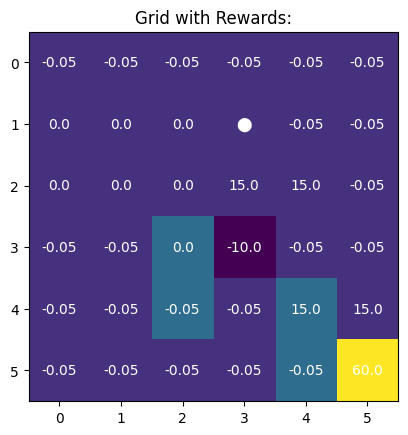

<IPython.core.display.Javascript object>

Total Reward Collected: -39.050000000000004


In [6]:
env = GridEnvironment(20)
agent = RandomAgent(env)
obs = env.reset()

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

total_reward = 0
timestep = 0
done = False

while not done:
  print('--------------------')
  print('Time Step :', timestep + 1)
  action = agent.step(obs)
  obs, reward, done, info = env.step(action)
  print("Info Dict: ", info)
  total_reward += reward
  timestep += 1

  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    env.render()
  # time.sleep(1)

print('Total Reward Collected:', total_reward)

## Part 3: Implementing Q - Learning and Evaluating Learning Table

In [7]:
# Method to choose action based on policy either greedy or random
def chooseAction(q_learning_table, state, epsilon):
    if np.random.uniform(0, 1) >= epsilon: # greedy
      action = np.argmax(q_learning_table[state, :])
    else: # random
      action = env.action_space.sample()
        
    return action
 
# Method to update the learning table using Q-Learning
def update_Q_LearningTable(q_learning_table, state, newState, reward, action, alpha, gamma):
    currentQValue = q_learning_table[state, action]
    maxQValue = np.max(q_learning_table[newState, :])
    nextQValue = reward + gamma * maxQValue
    q_learning_table[state, action] = q_learning_table[state, action] + alpha * (nextQValue - currentQValue)


In [8]:
def QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay=0.01):
    # Initializing variables
    decay_counter = 0.001 * total_episodes
    decay_factor = ep_decay
    cumulative_reward = 0
    successful_episodes = []
    timesteps_per_episode = []
    statistics_per_episode = {"Episode": [], "Episode_Reward": [], "Cumulative_Reward": [], "Epsilon": []}

    # Initializing the learning table

    q_learning_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    # Starting the Training of the Model
    for episode in range(total_episodes):
        timeStep = 0
        currentState = env.reset()
        action = chooseAction(q_learning_table, currentState, epsilon)
        episodeReward = 0
        print('----Starting Episode ', episode+1, '----')
        
        while timeStep < maximum_steps:
            newState, reward, done, info = env.step(action)
            nextAction = chooseAction(q_learning_table, newState, epsilon)
            
            # Update the Learning Table
            update_Q_LearningTable(q_learning_table, currentState, newState, reward, action, alpha, gamma)
            currentState = newState
            action = nextAction
            
            # Updating the respective values for reporting
            timeStep += 1
            episodeReward += reward
            cumulative_reward += reward
            
            # Execute if Agent Reaches the Goal State
            if done:
                print('Agent has Reached Goal')
                successful_episodes.append(episode)
                timesteps_per_episode.append(timeStep)
                break
        
        statistics_per_episode["Episode"].append(episode+1)
        statistics_per_episode["Episode_Reward"].append(episodeReward)
        statistics_per_episode["Cumulative_Reward"].append(cumulative_reward)
        statistics_per_episode["Epsilon"].append(epsilon)
        
        if episode > 0 and episode % decay_counter == 0:
            epsilon -= (epsilon * decay_factor)
            print('New Epsilon:', epsilon)
            
        if epsilon < 0.05:
            epsilon = 0.05
    
    return statistics_per_episode, epsilon, q_learning_table, timesteps_per_episode, cumulative_reward


In [9]:
def plot_different_graphs(statistics_per_episode, timesteps_per_episode):

  # Cumulative reward graph
  plt.figure(figsize=(10,10))
  plt.plot(statistics_per_episode['Episode'], statistics_per_episode['Cumulative_Reward'])
  plt.grid()
  plt.title('Cumulative Reward over Training Episodes')
  plt.xlabel('Episodes')
  plt.ylabel('Cumulative Reward')
  plt.show()

  print("\n\n")

  # Per episode reward graph
  plt.figure(figsize=(10,10))
  plt.plot(statistics_per_episode['Episode'], statistics_per_episode['Episode_Reward'])
  plt.grid()
  plt.title('Total Reward per Training Episodes')
  plt.xlabel('Episodes')
  plt.ylabel('Total Reward')
  plt.show()

  print("\n\n")

  # Epsilon Decay graph
  plt.figure(figsize=(10,10))
  plt.plot(statistics_per_episode['Episode'], statistics_per_episode['Epsilon'])
  plt.grid()
  plt.title('Epsilon Decay Across Episodes')
  plt.xlabel('Episodes')
  plt.ylabel('Epsilon')
  plt.show()

  print("\n\n")

  # Episode Reward for changin epsilon value per episode
  plt.figure(figsize=(10,10))
  plt.plot(statistics_per_episode['Epsilon'], statistics_per_episode['Episode_Reward'])
  plt.grid()
  plt.title('Decrease of Total Reward with increase in Epsilon (per episode)')
  plt.xlabel('Epsilon(per episode)')
  plt.ylabel('Total Reward')
  plt.show()

  print("\n\n")

  # Timestep taken to reach the goal
  plt.figure(figsize=(10,10))
  plt.scatter(statistics_per_episode['Episode'], timesteps_per_episode)
  plt.grid()
  plt.title('TimeSteps taken to reach the goal')
  plt.xlabel('Episodes')
  plt.ylabel('Time Steps taken per episode')
  plt.show()

In [10]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 20
alpha = 0.1
gamma = 0.9
ep_decay = 0.01

env = GridEnvironment(20)
agent = RandomAgent(env)

statistics_per_episode, final_epsilon, q_learning_table, timesteps_per_episode, abs_final_cumulative_reward = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.98505
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.9751995
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.965447505
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.9557930299499999
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.9462350996504999
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.9367727486539948
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.9274050211674549
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.9181309709557803
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.9089496612462226
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.8998601646337603
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.8908615629874227
----Starting Episode  13 ----
Agent has Reached 

In [11]:
print('Final Epsilon:', final_epsilon)

Final Epsilon: 0.05


In [12]:
# Visualizing the Q-leaning table
print(q_learning_table)

[[ 52.91656422  24.51039361   8.96523408  24.36972159]
 [ -7.67241787 -10.76355759  23.32142269  -2.09572834]
 [ 47.3004709   -8.52268575  -1.63035753  -1.82784323]
 [ -0.52490023  -5.87502844  -1.40835715  -1.21309946]
 [ -0.9501836   -6.23970495  -1.55877836  -0.7157521 ]
 [ -0.93819     -3.7217296   -4.4549282   -1.18328436]
 [ 58.87060771  30.48682759  19.02281825  33.99500504]
 [  1.4607885   -1.61807604  54.93551888  -0.9112991 ]
 [ 71.85389635   0.78689398  -0.26051054   1.18701402]
 [  4.34519473  -1.46144405  -0.5938551   -0.38039722]
 [ -0.6194778   -1.22116291  -0.405       -0.7215443 ]
 [ -0.243801    -0.897844    -1.4          0.        ]
 [ 16.82986285  44.15457931  65.49717208  31.77318626]
 [ 50.52172698   7.82767859  72.93629983  39.01776654]
 [ 81.33383639  50.12643871  37.02507084  45.82391705]
 [ -4.33104377  -1.20301989  -1.05642672  61.37384001]
 [  3.88664096  -1.09992805  -0.501206     5.85319941]
 [ -0.3384      -0.6621      -3.262996    -0.44401   ]
 [ -0.7077

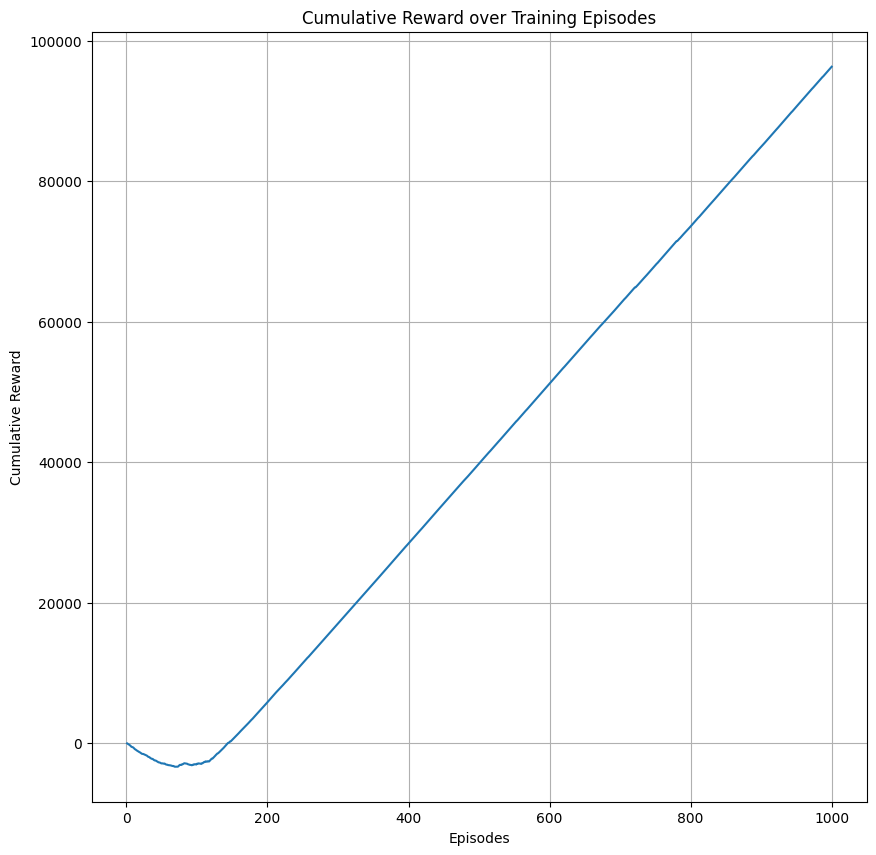

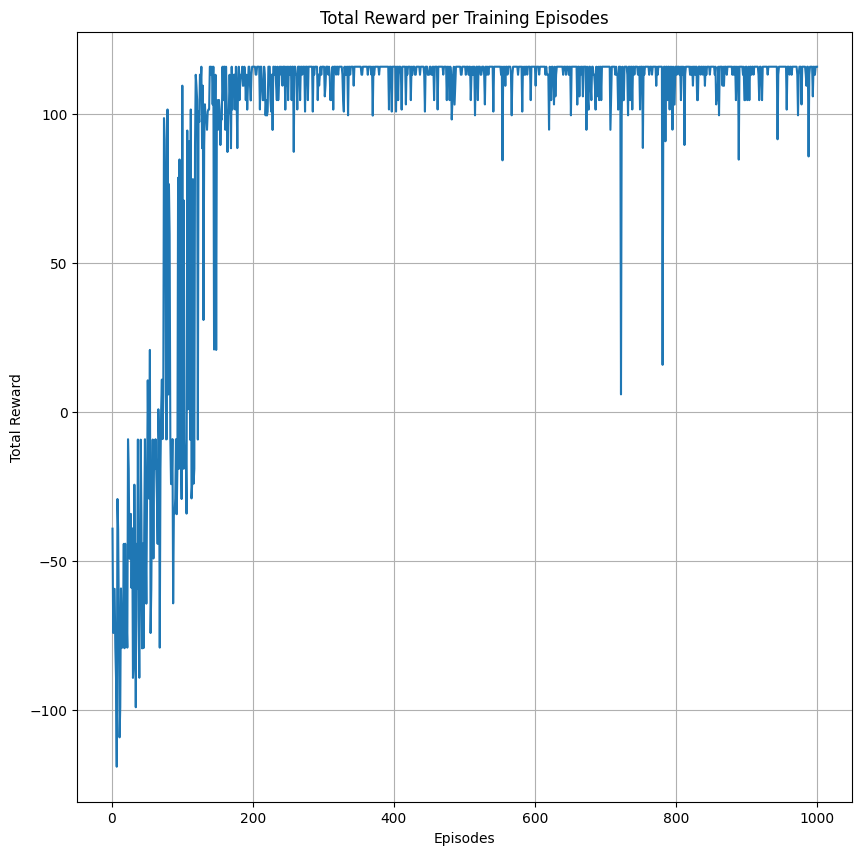

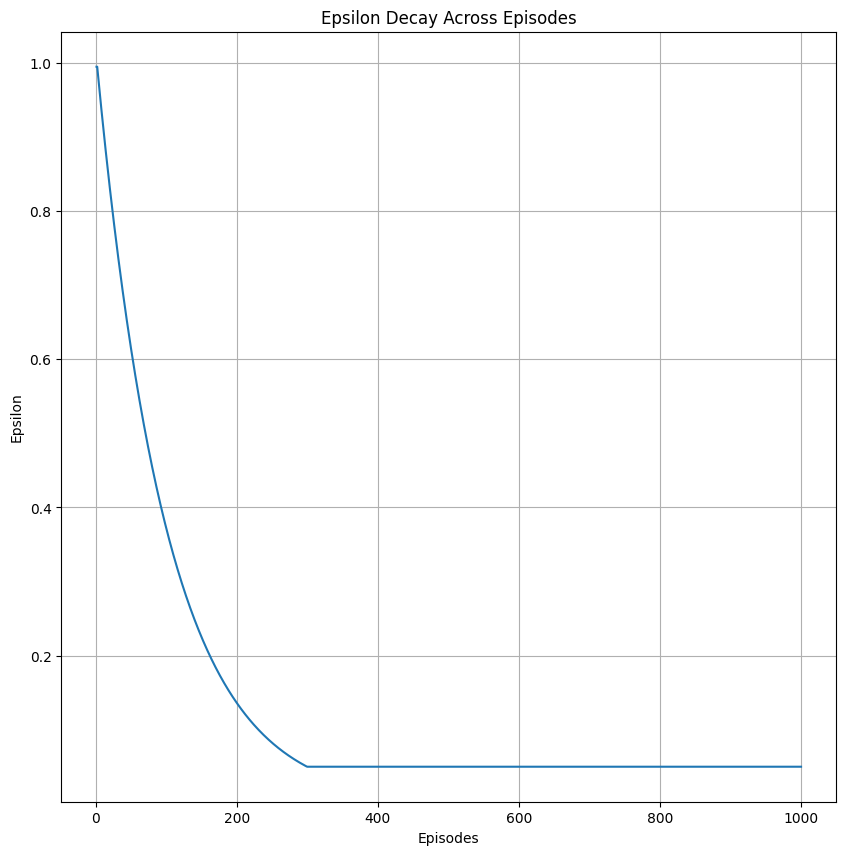

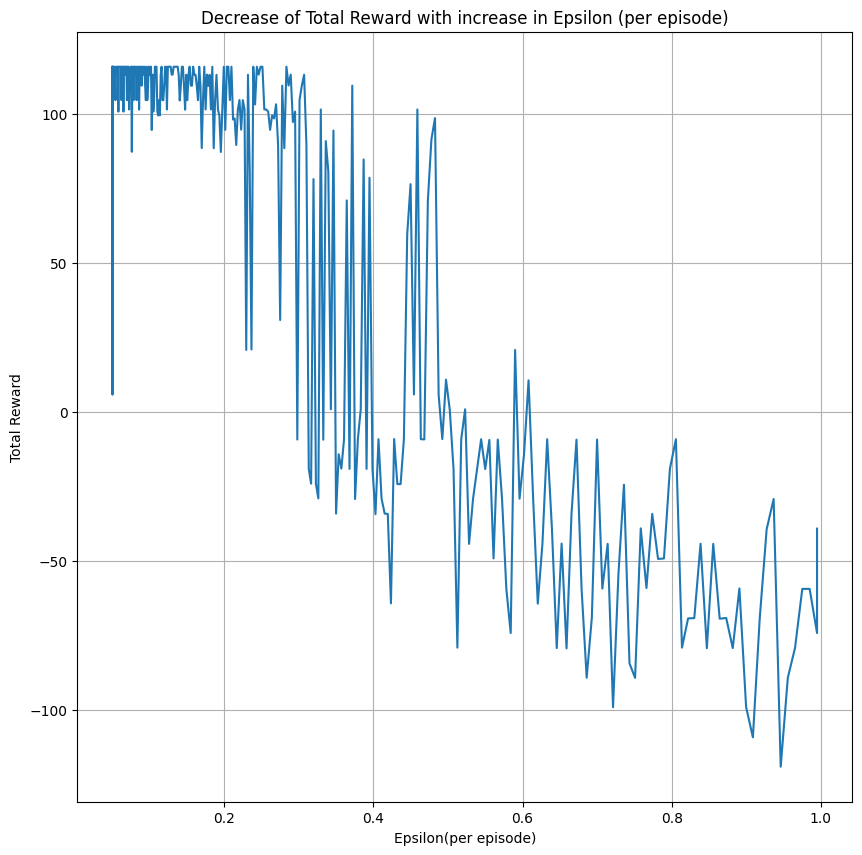

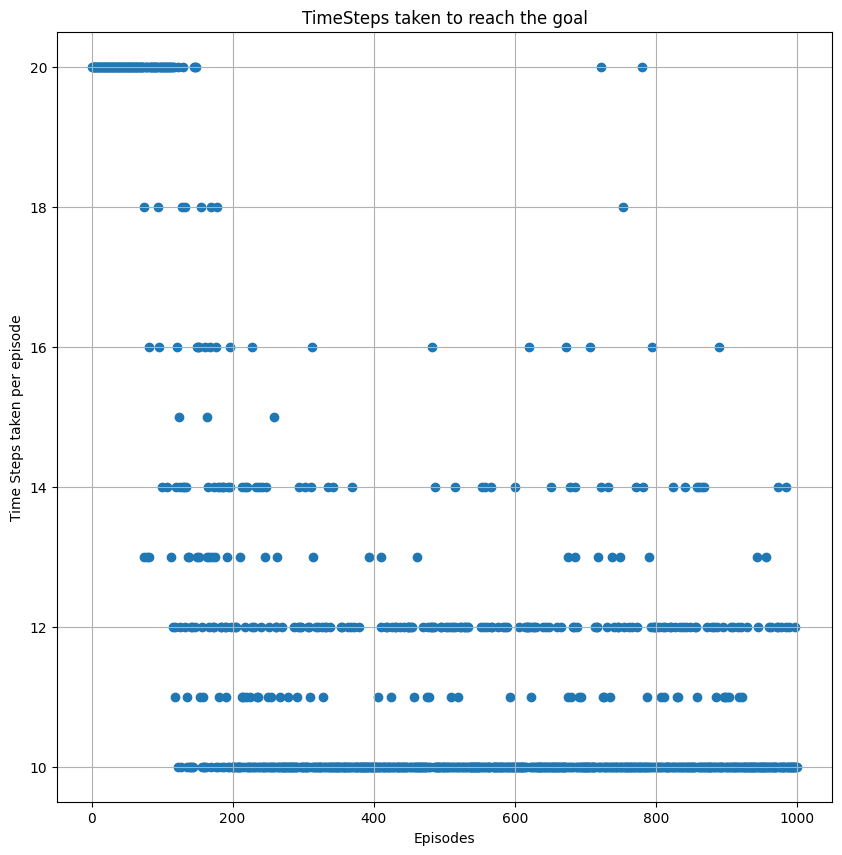

In [13]:
plot_different_graphs(statistics_per_episode, timesteps_per_episode)

## Paths taken by the agent after Q-Learing

Test Episode: 1: Agent at starting position (0, 0)


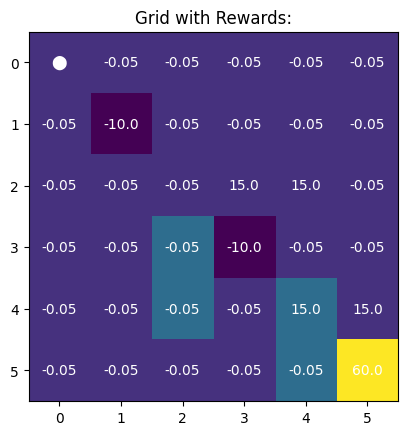

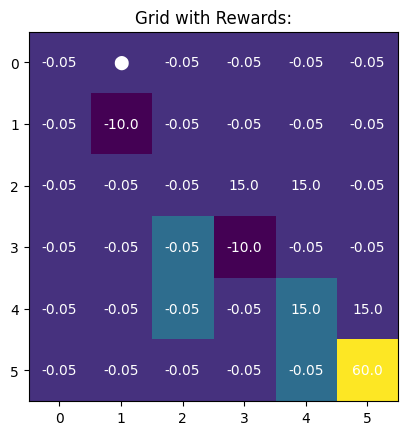

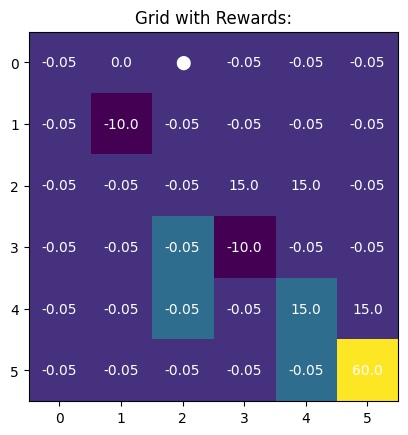

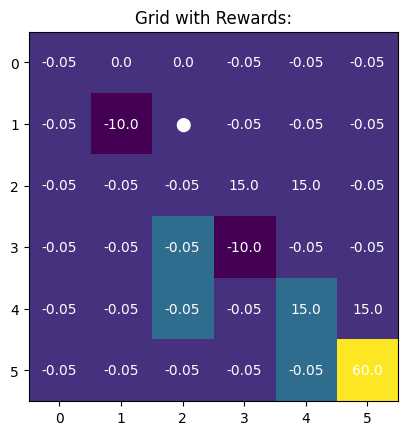

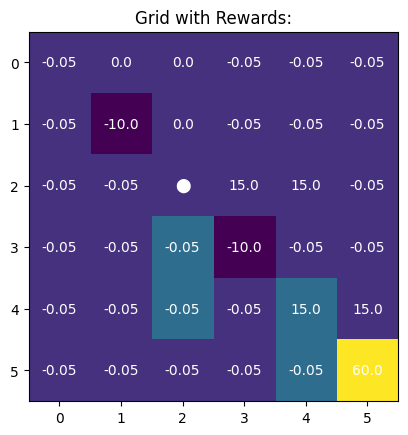

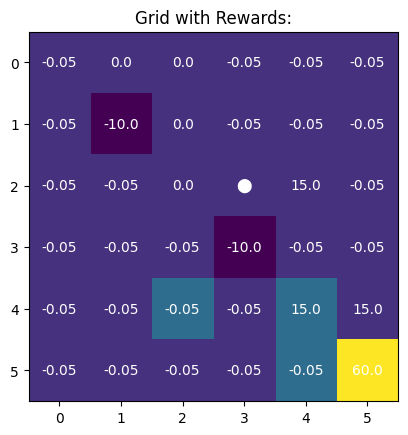

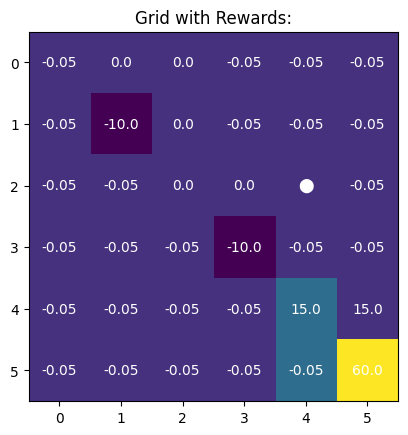

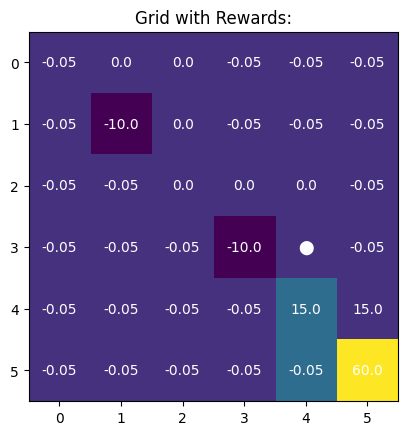

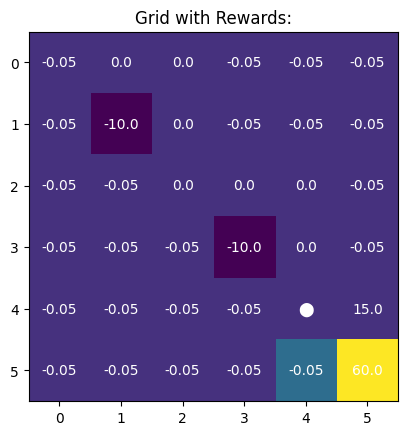

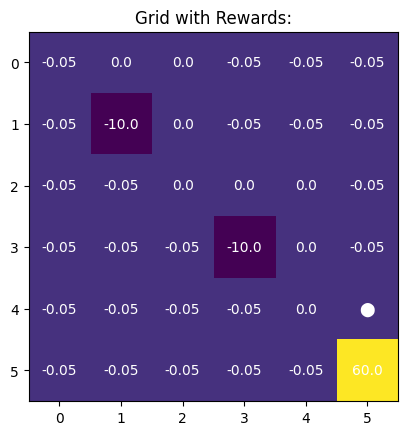

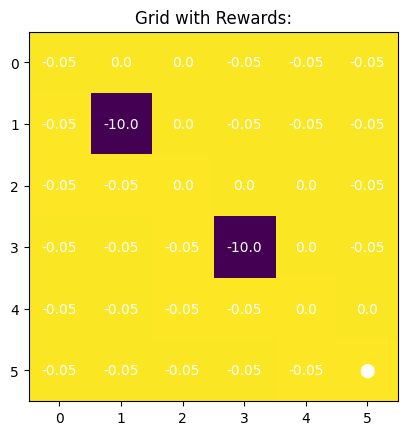



Agent has Reached Goal!
Test Episode: 2: Agent at starting position (0, 0)


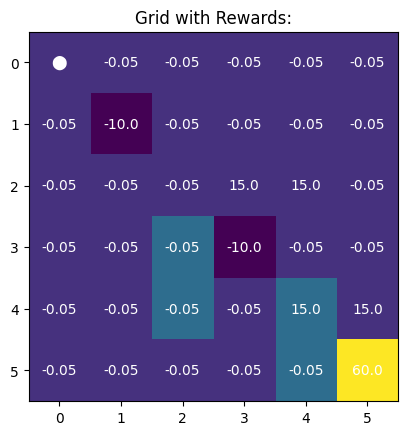

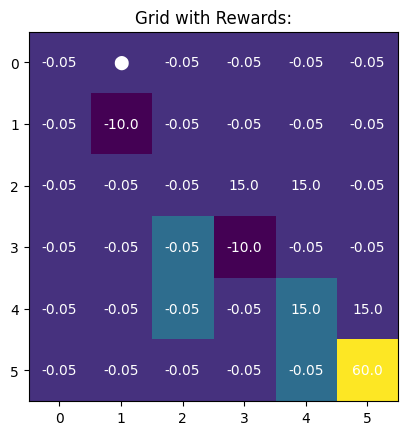

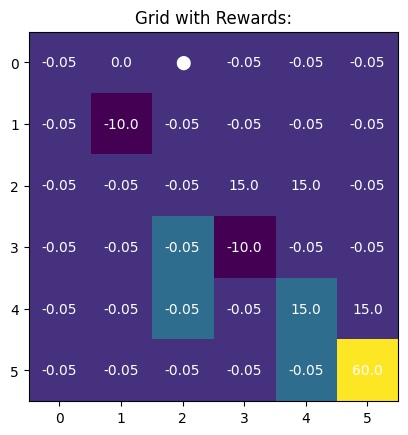

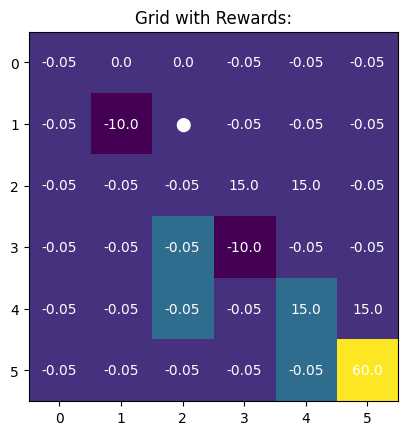

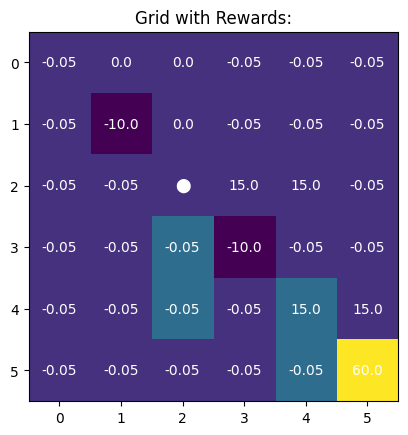

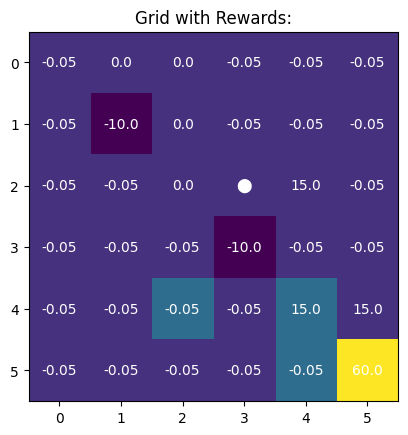

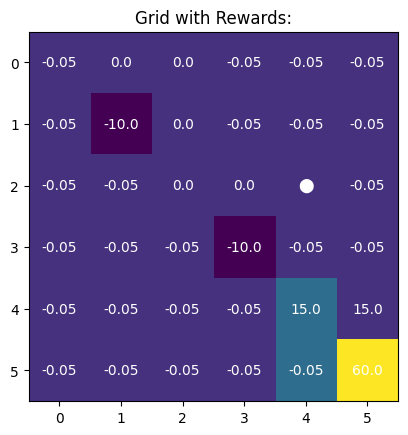

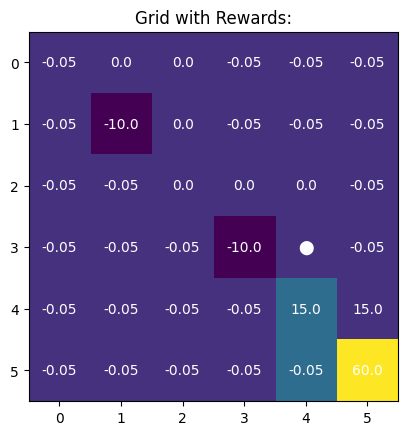

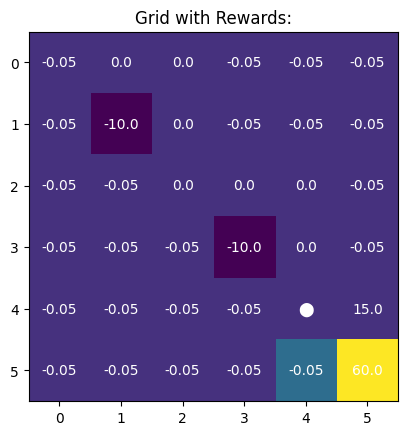

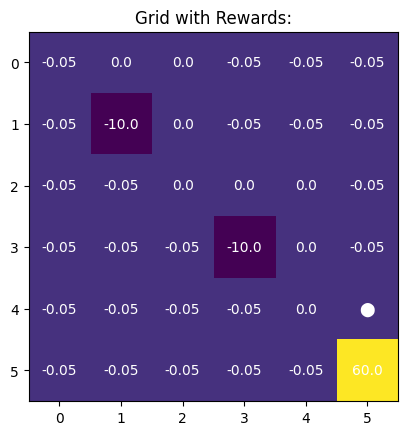

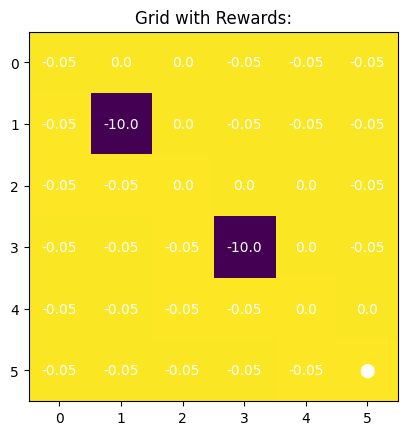



Agent has Reached Goal!
Test Episode: 3: Agent at starting position (0, 0)


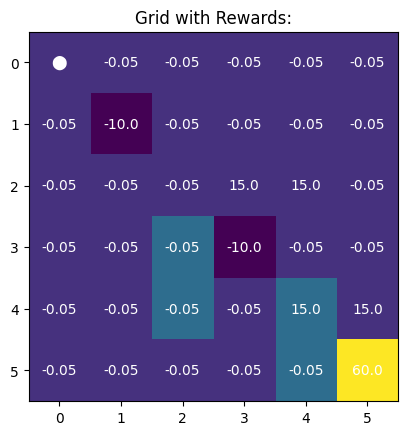

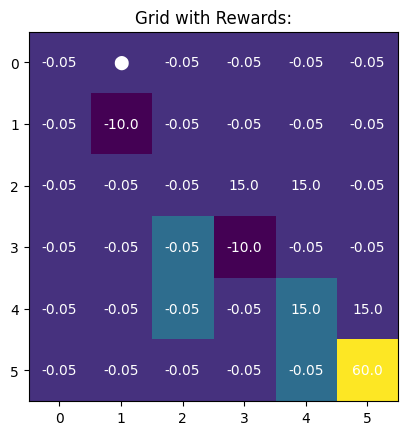

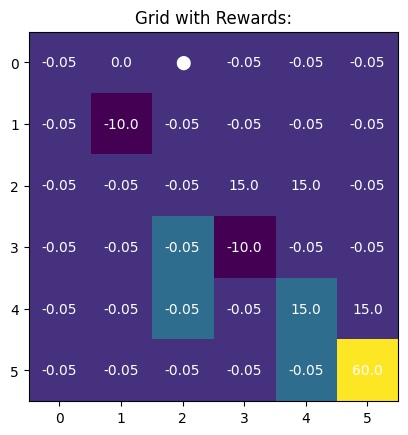

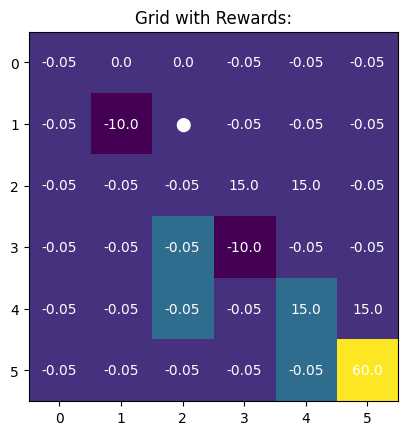

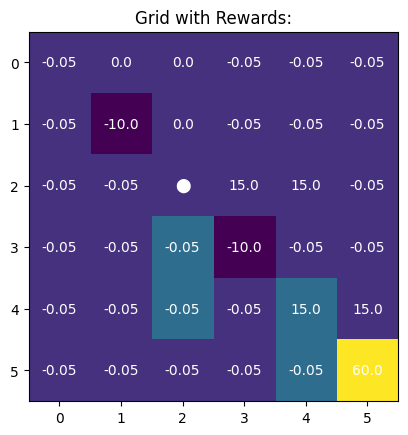

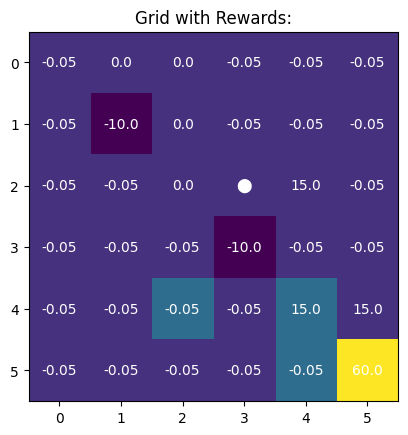

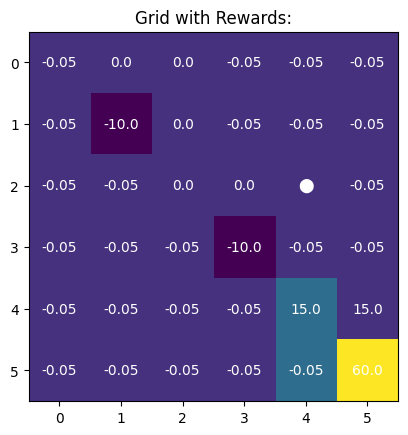

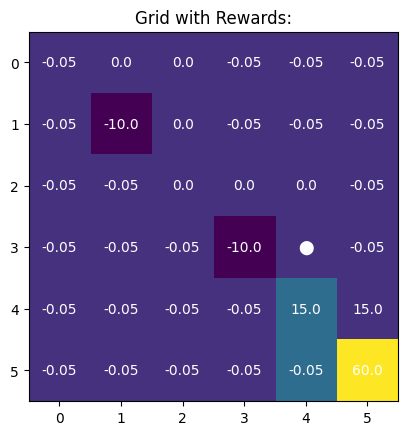

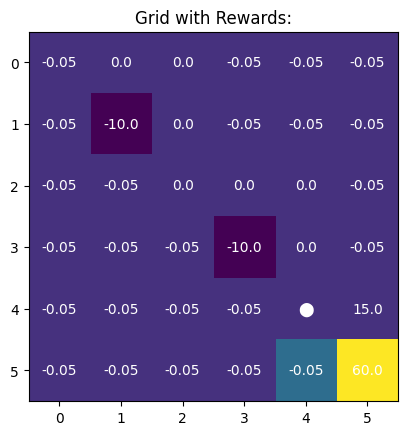

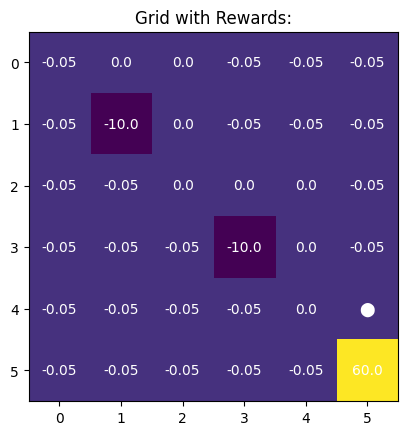

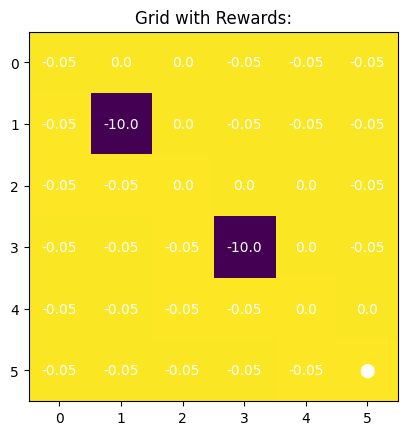



Agent has Reached Goal!
Test Episode: 4: Agent at starting position (0, 0)


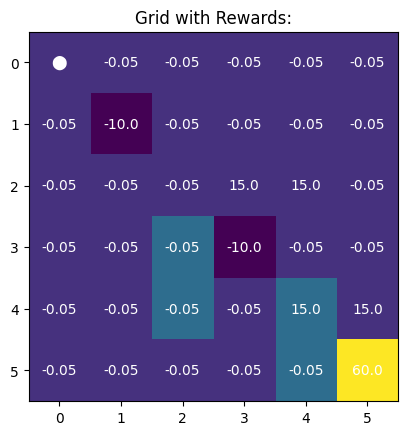

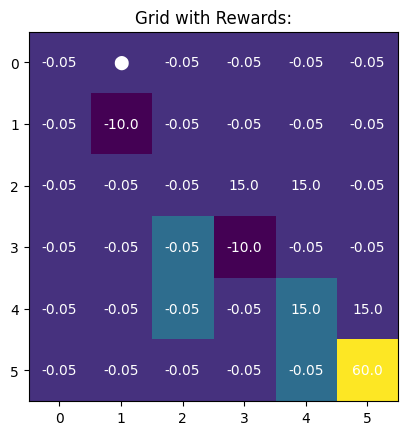

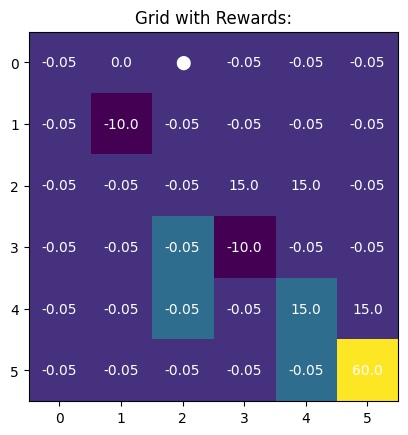

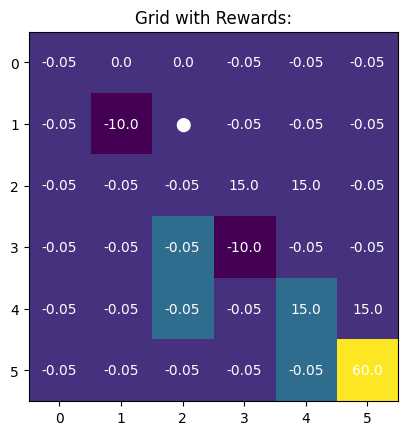

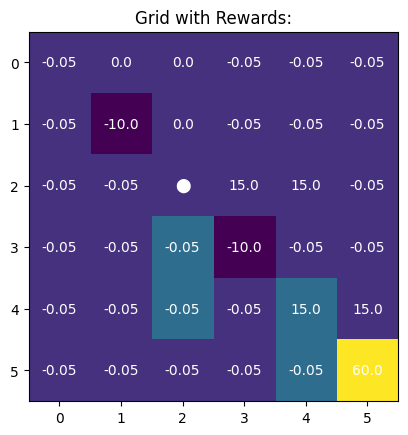

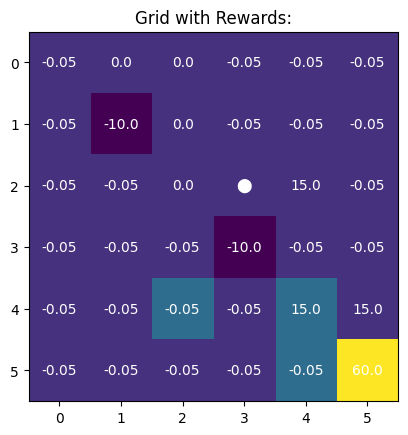

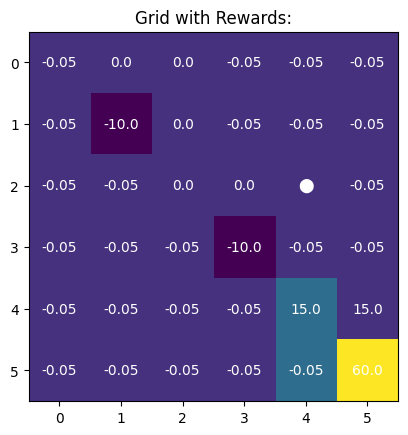

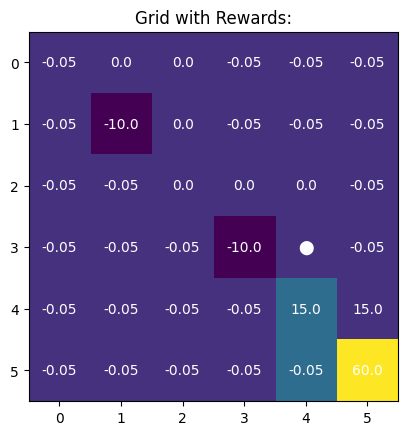

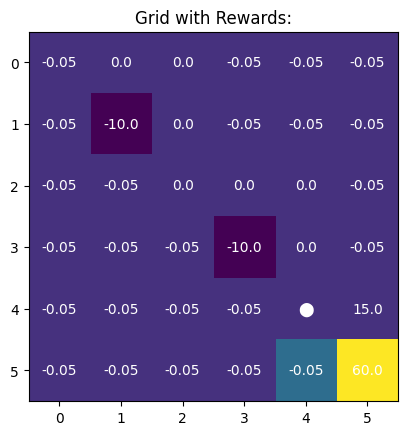

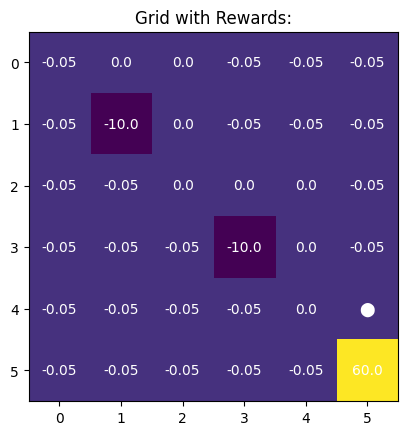

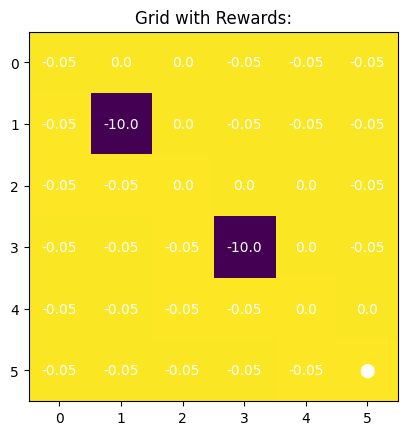



Agent has Reached Goal!


In [14]:
paths_taken_for_all_episodes = []

for testEpisodes in range(1, 5):
    print(f'Test Episode: {testEpisodes}: Agent at starting position (0, 0)')
    state = env.reset()
    pathTaken = [state]
    totalTestReward = 0

    env.render()
    print("\n")
    
    for i in range(20):
        action = np.argmax(q_learning_table[state, :])
        state, reward, done, info = env.step(action)
        pathTaken.append(state)
        totalTestReward += reward

        #print(info)
        #print("Done Value:", done)

        env.render()
        print("\n")
        if done:
            print('Agent has Reached Goal!')
            break
    
    paths_taken_for_all_episodes.append({'pathTaken': pathTaken, 'totalTestReward': totalTestReward})

### Printing the paths taken by the agent afer training

In [15]:
test_episode_ctr = 1
for path in paths_taken_for_all_episodes:
  print(f"Path taken for Test Episode {test_episode_ctr} from State '0' is as follows: {path}")
  test_episode_ctr += 1

Path taken for Test Episode 1 from State '0' is as follows: {'pathTaken': [0, 6, 12, 13, 14, 20, 26, 27, 28, 34, 35], 'totalTestReward': 115.9}
Path taken for Test Episode 2 from State '0' is as follows: {'pathTaken': [0, 6, 12, 13, 14, 20, 26, 27, 28, 34, 35], 'totalTestReward': 115.9}
Path taken for Test Episode 3 from State '0' is as follows: {'pathTaken': [0, 6, 12, 13, 14, 20, 26, 27, 28, 34, 35], 'totalTestReward': 115.9}
Path taken for Test Episode 4 from State '0' is as follows: {'pathTaken': [0, 6, 12, 13, 14, 20, 26, 27, 28, 34, 35], 'totalTestReward': 115.9}


In [16]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward, 2)}")

Absolute total cumulative reward achived in 1000: 96305.75


# Hypterparamter Tuning

## Setup 1:

| Discount Factor | **Epsilon Decay Rate** | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| 0.9 | **0.05** | 20 | 1000 |

In [17]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 20
alpha = 0.1
gamma = 0.9
ep_decay = 0.05

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode1, final_epsilon1, q_learning_table1, timesteps_per_episode1, abs_final_cumulative_reward1 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.94525
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.8979875
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.8530881250000001
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.81043371875
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.7699120328125
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.7314164311718749
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.6948456096132812
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.6601033291326172
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6270981626759863
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.595743254542187
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.5659560918150777
----Starting Episode  13 ----
Agent has Reached Go

In [18]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward1, 2)}")

Absolute total cumulative reward achived in 1000: 108606.85


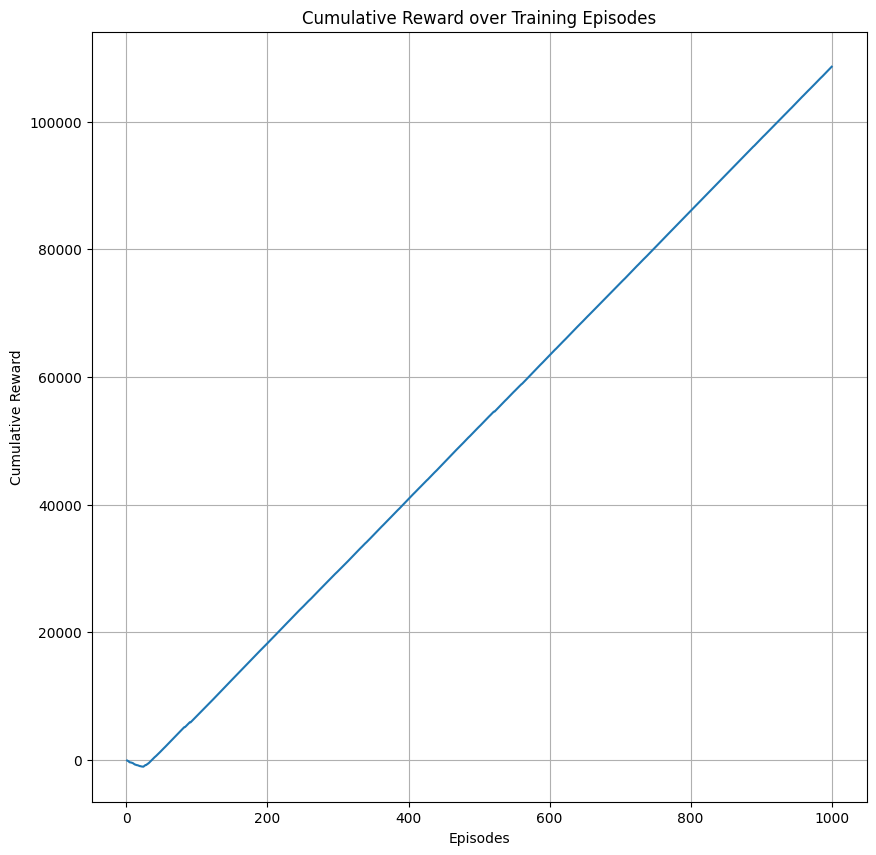

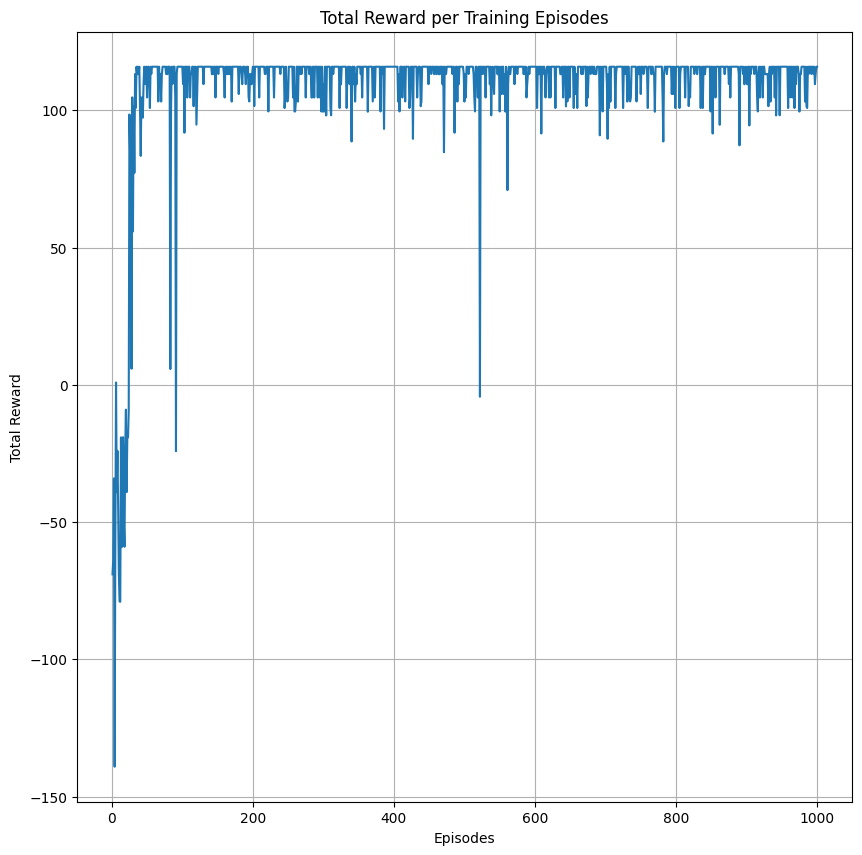

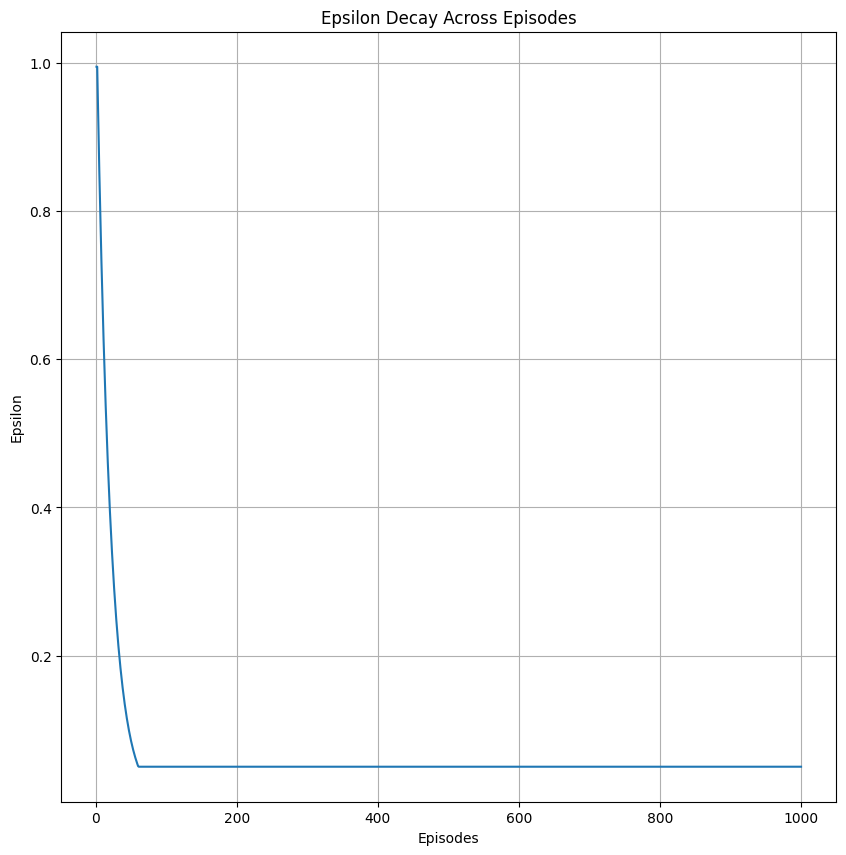

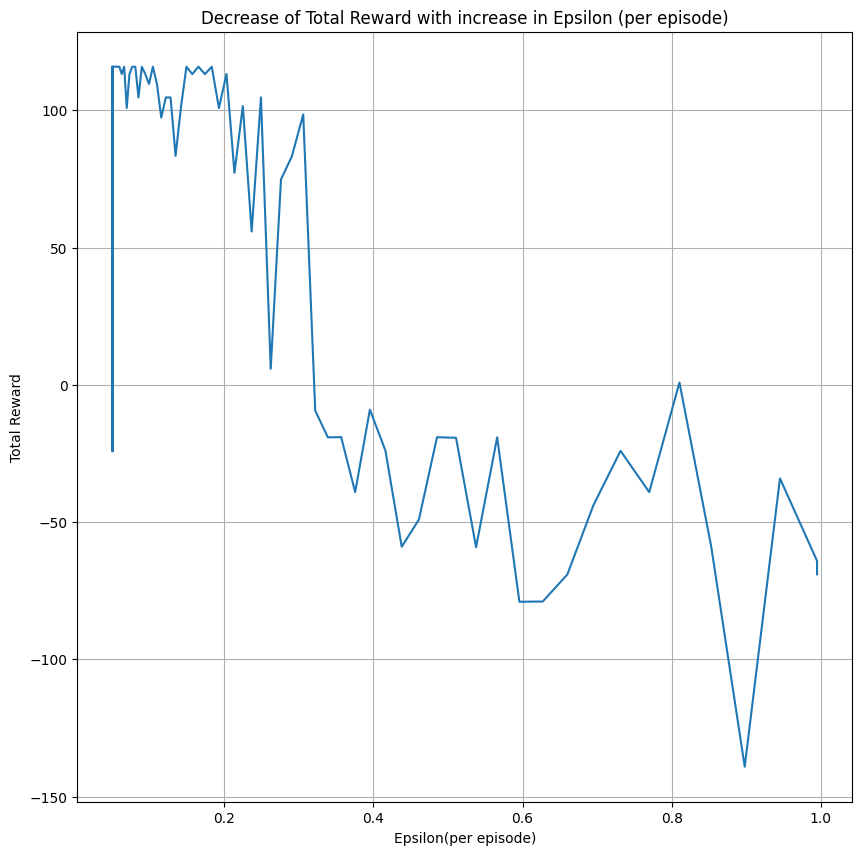

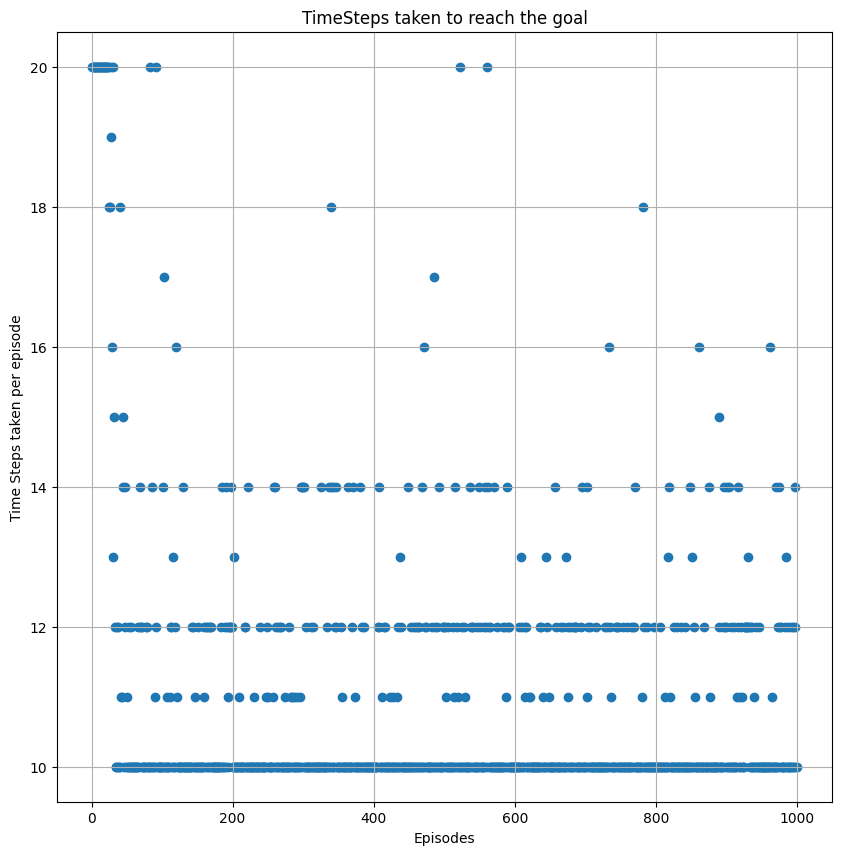

In [19]:
plot_different_graphs(statistics_per_episode1, timesteps_per_episode1)

## Setup 2:

| Discount Factor | **Epsilon Decay Rate** | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| 0.9 | **0.1** | 20 | 1000 |

In [20]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 20
alpha = 0.1
gamma = 0.9
ep_decay = 0.1

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode2, final_epsilon2, q_learning_table2, timesteps_per_episode2, abs_final_cumulative_reward2 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.8955
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.8059499999999999
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.725355
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.6528195
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.58753755
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.528783795
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.47590541549999993
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.42831487394999995
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.385483386555
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.34693504789949997
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.31224154310955
----Starting Episode  13 ----
Agent has Reached Goal
New Epsilon: 0.28

In [21]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward2, 2)}")

Absolute total cumulative reward achived in 1000: 109969.93


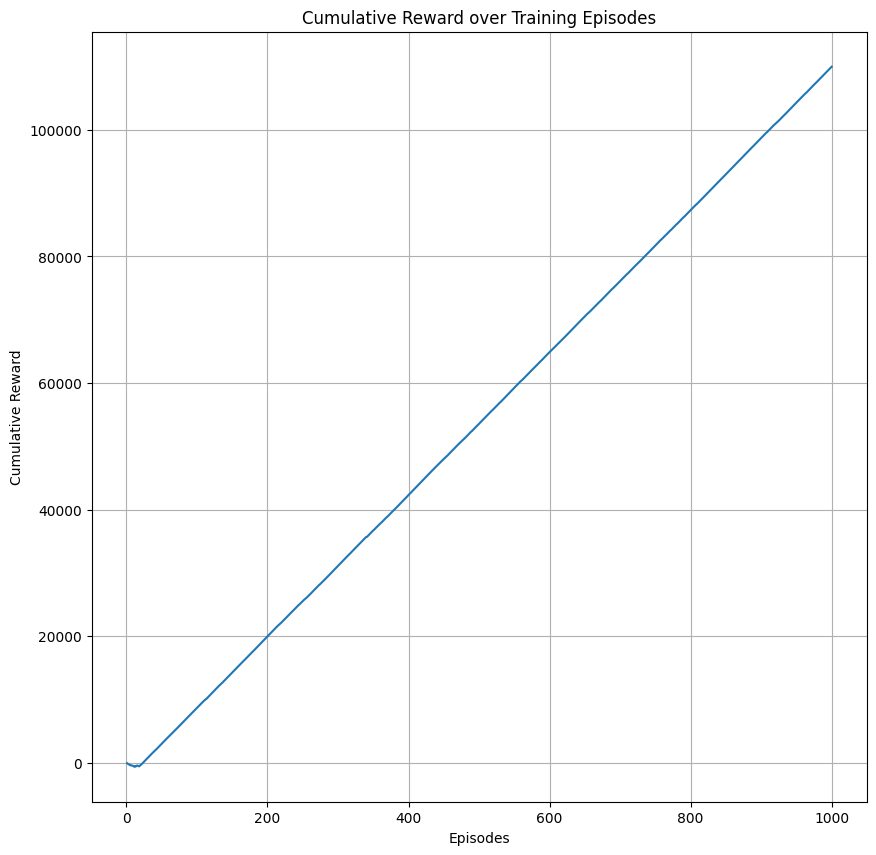

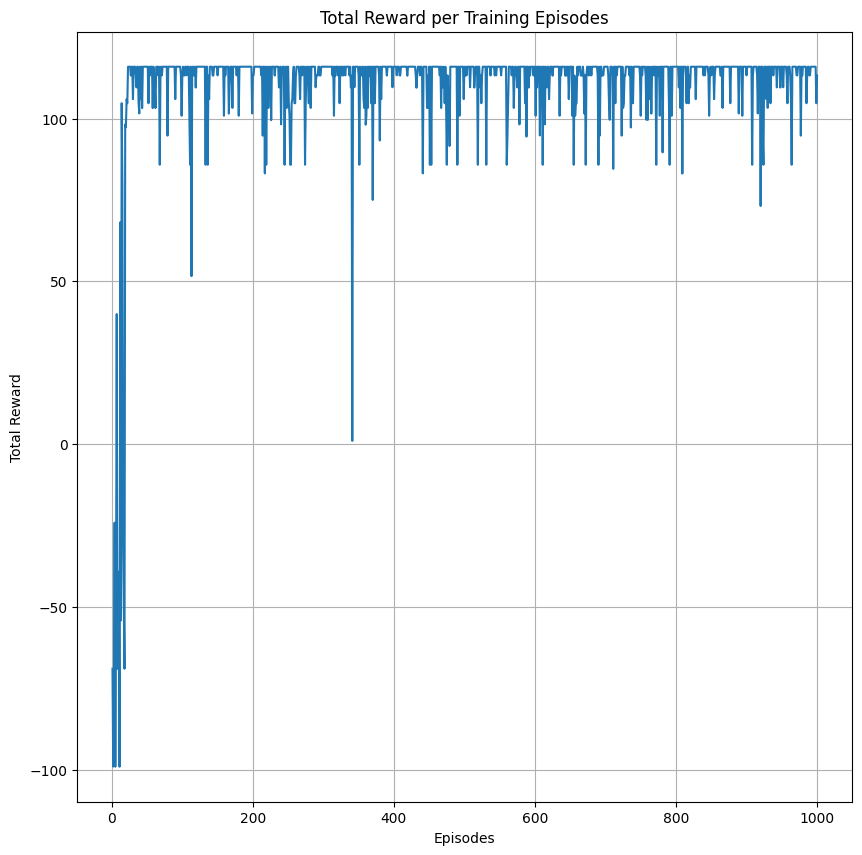

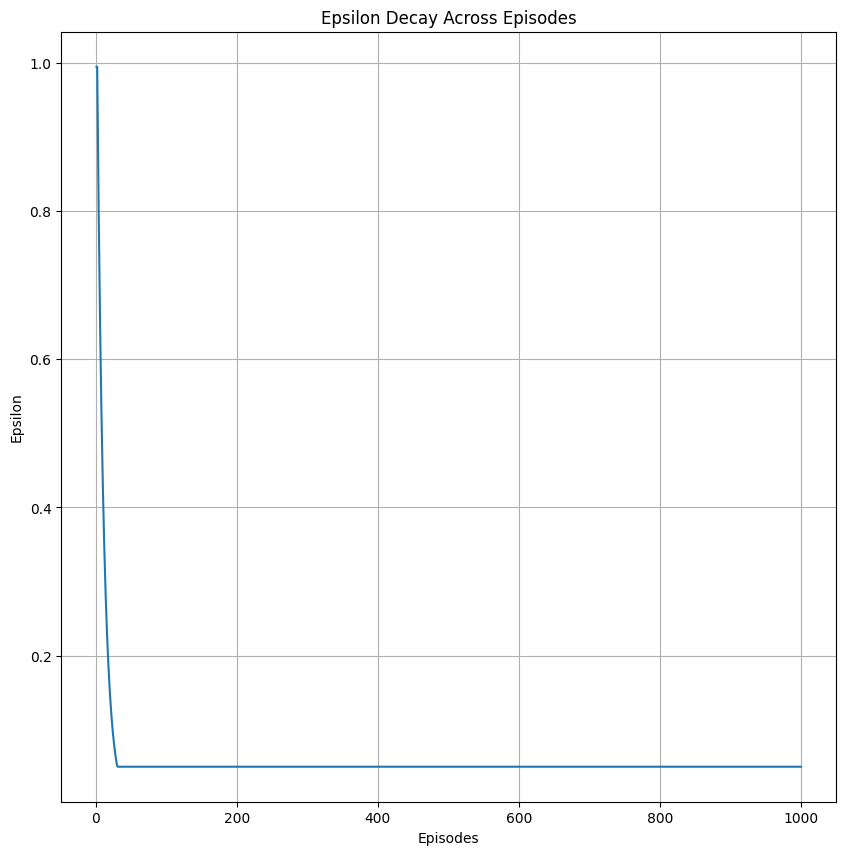

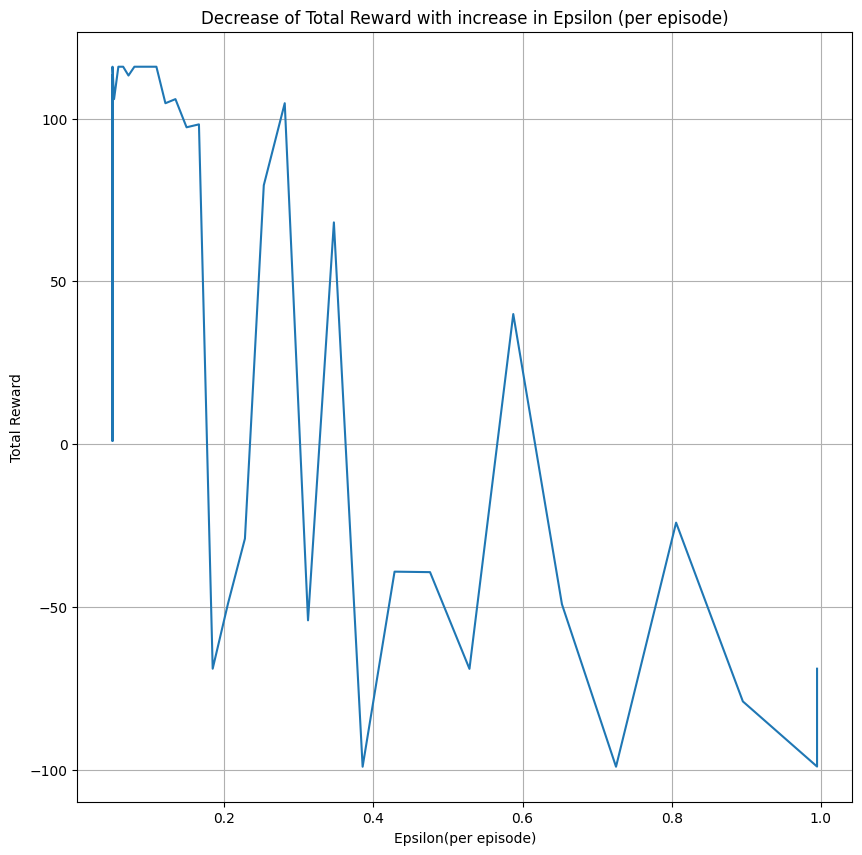

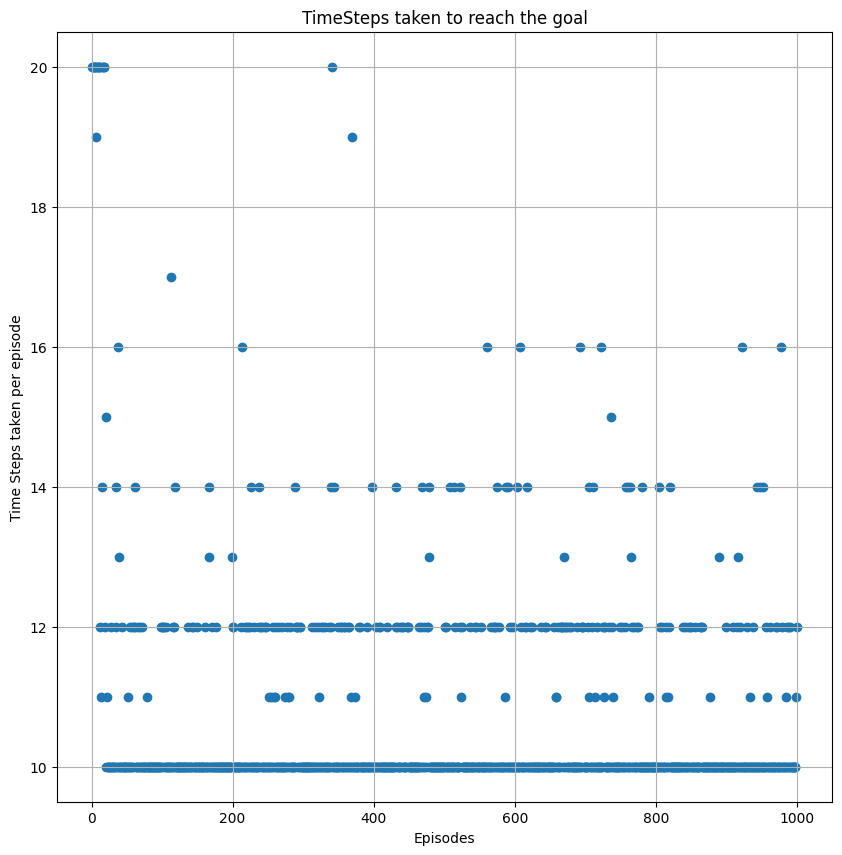

In [22]:
plot_different_graphs(statistics_per_episode2, timesteps_per_episode2)

## Setup 3:

| **Discount Factor** | Epsilon Decay Rate | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| **0.6** | 0.04 | 20 | 1000 |

In [23]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 20
alpha = 0.1
gamma = 0.6
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode3, final_epsilon3, q_learning_table3, timesteps_per_episode3, abs_final_cumulative_reward3 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.9552
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.916992
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.88031232
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.8450998272
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.811295834112
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.77884400074752
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.7476902407176192
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.7177826310889145
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6890713258453579
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.6615084728115436
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.6350481338990819
----Starting Episode  13 ----
Agent has Reached Goal
New Epsilo

In [24]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward3, 2)}")

Absolute total cumulative reward achived in 1000: 106933.96


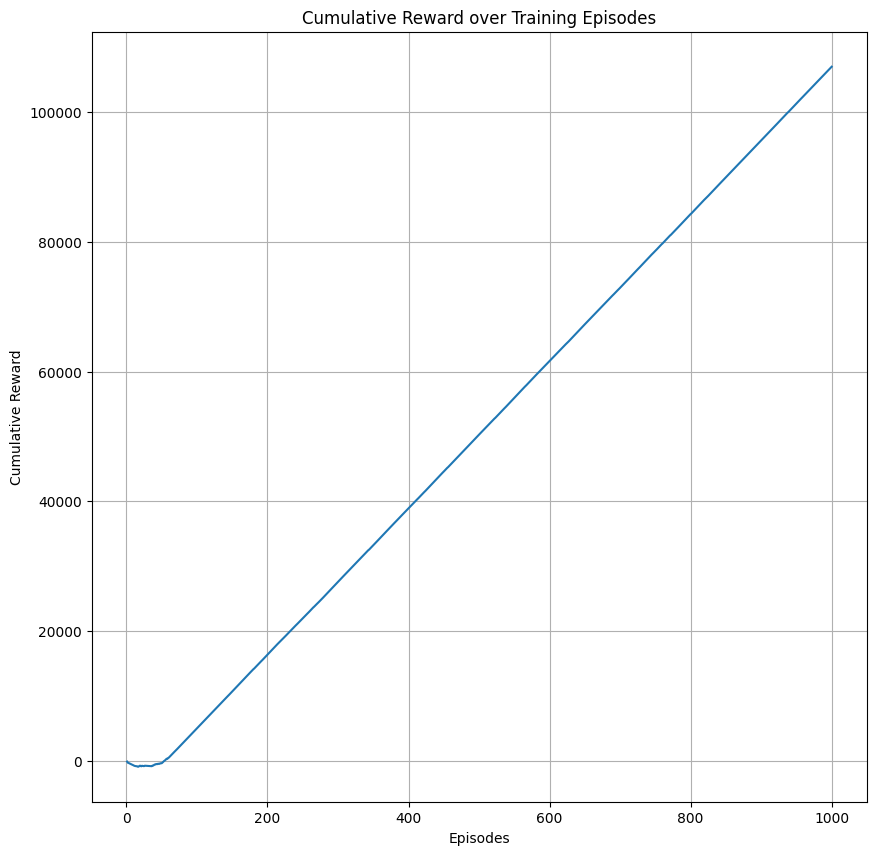

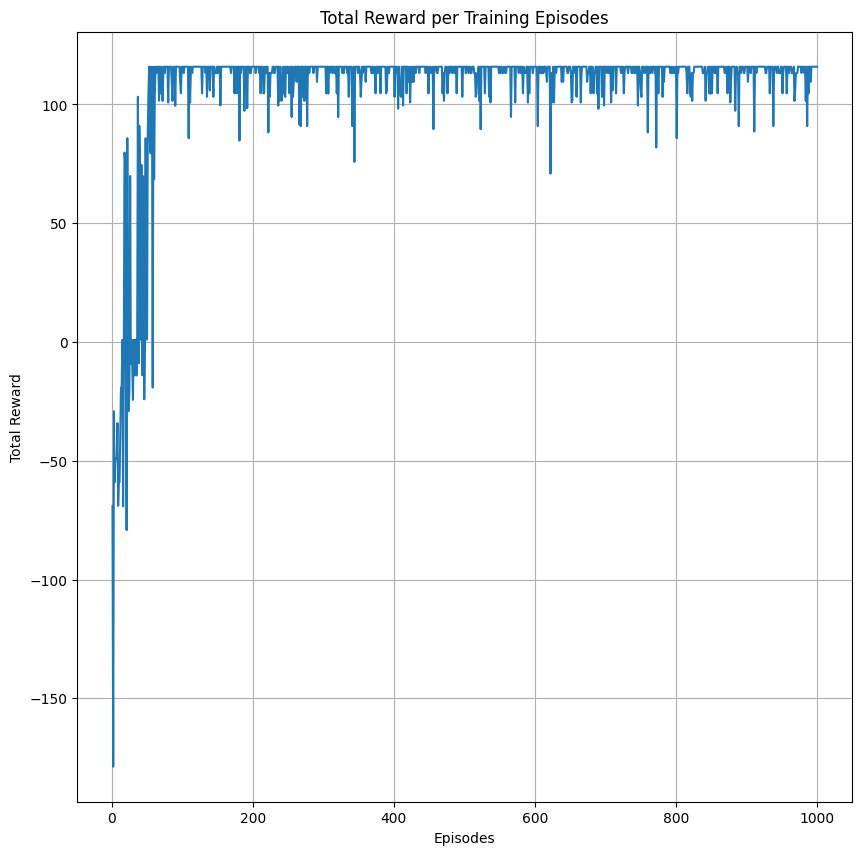

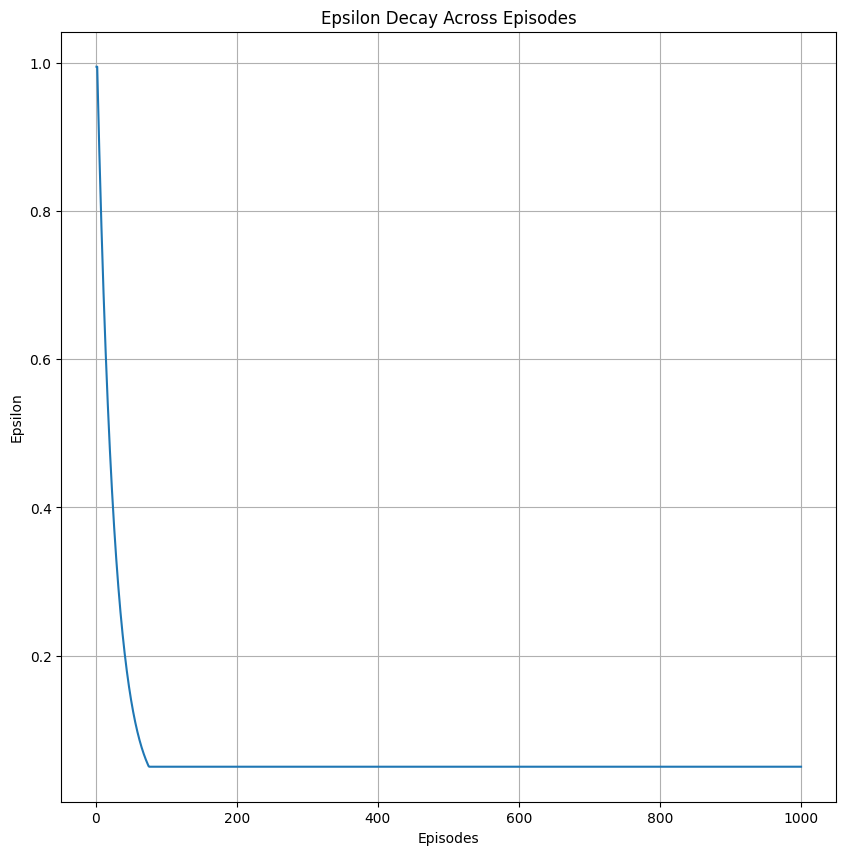

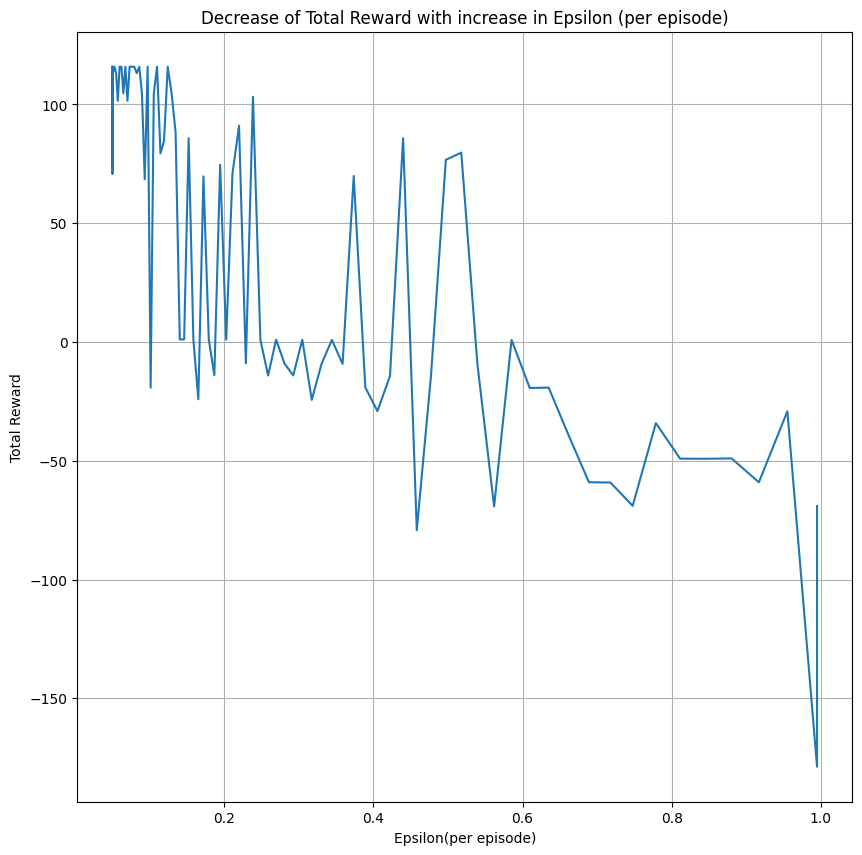

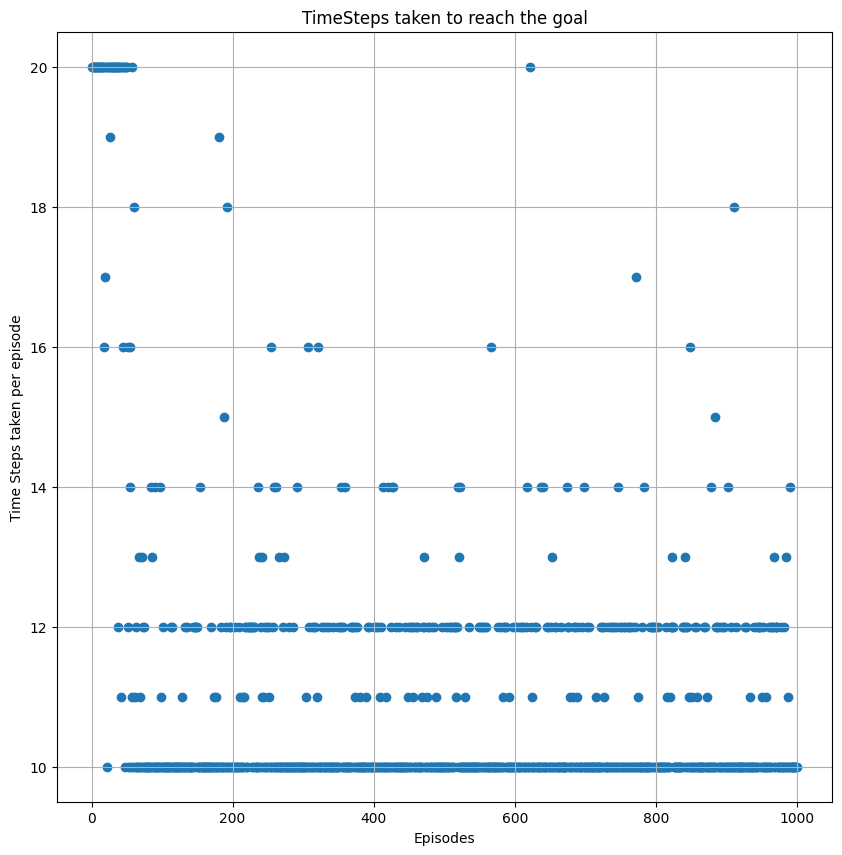

In [25]:
plot_different_graphs(statistics_per_episode3, timesteps_per_episode3)

## Setup 4:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| **0.4** | 0.04 | 20 | 1000 |

In [26]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 20
alpha = 0.1
gamma = 0.4
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode4, final_epsilon4, q_learning_table4, timesteps_per_episode4, abs_final_cumulative_reward4 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.9552
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.916992
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.88031232
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.8450998272
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.811295834112
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.77884400074752
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.7476902407176192
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.7177826310889145
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6890713258453579
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.6615084728115436
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.6350481338990819
----Starting Episode  13 ----
Agent has Reached Goal
New Epsilo

In [27]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward4, 2)}")

Absolute total cumulative reward achived in 1000: 107124.87


In [28]:
print(len(timesteps_per_episode4))

1000


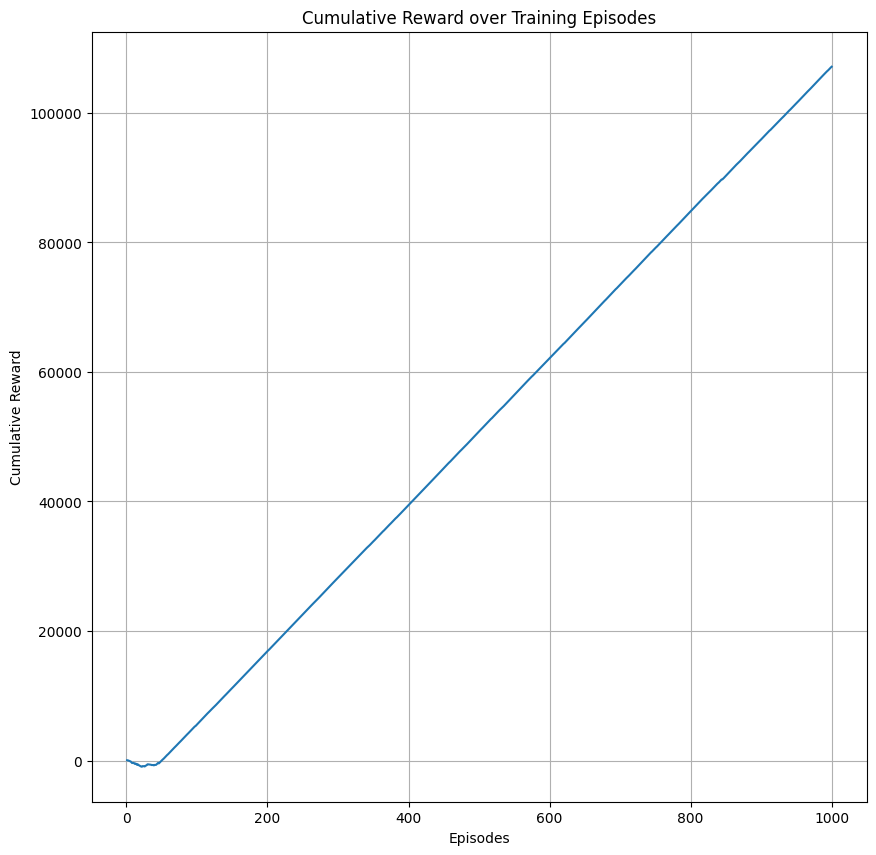

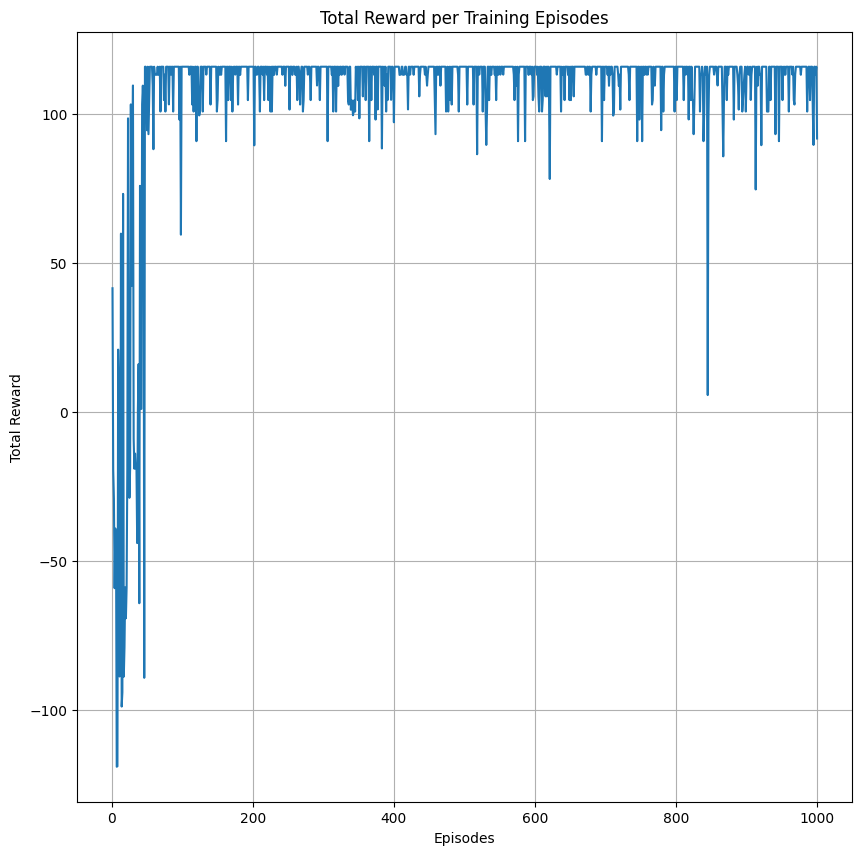

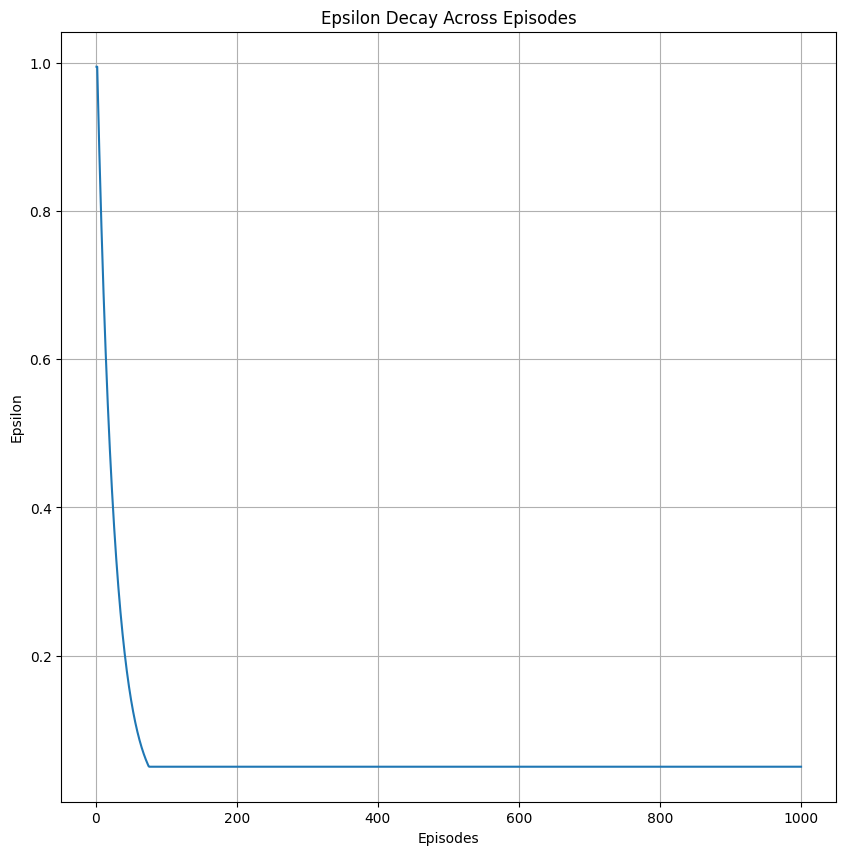

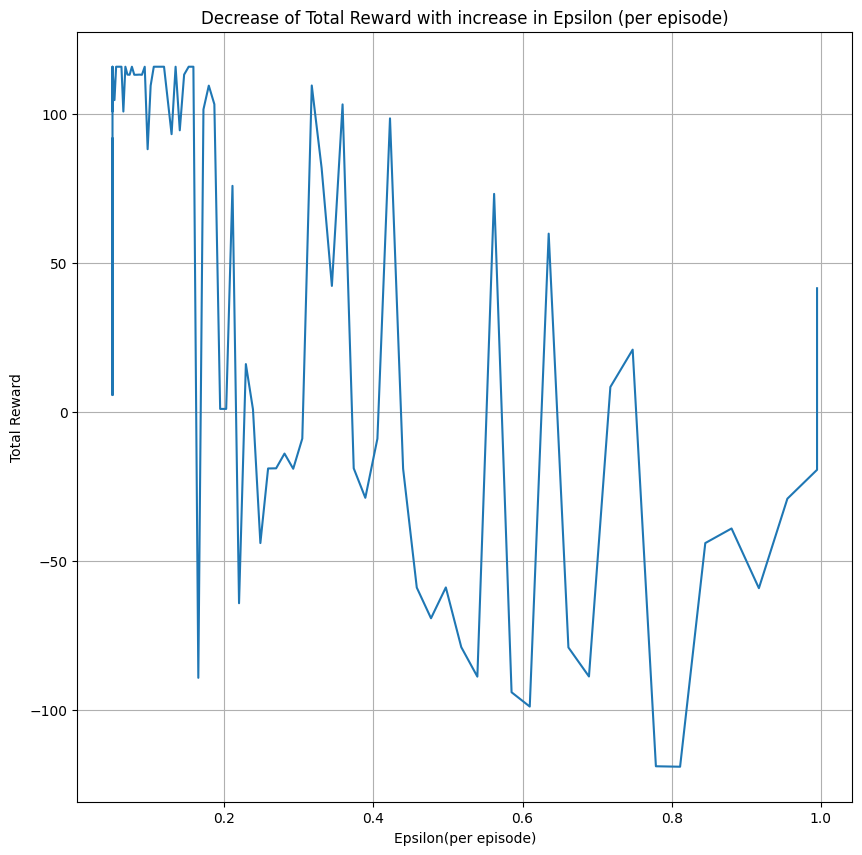

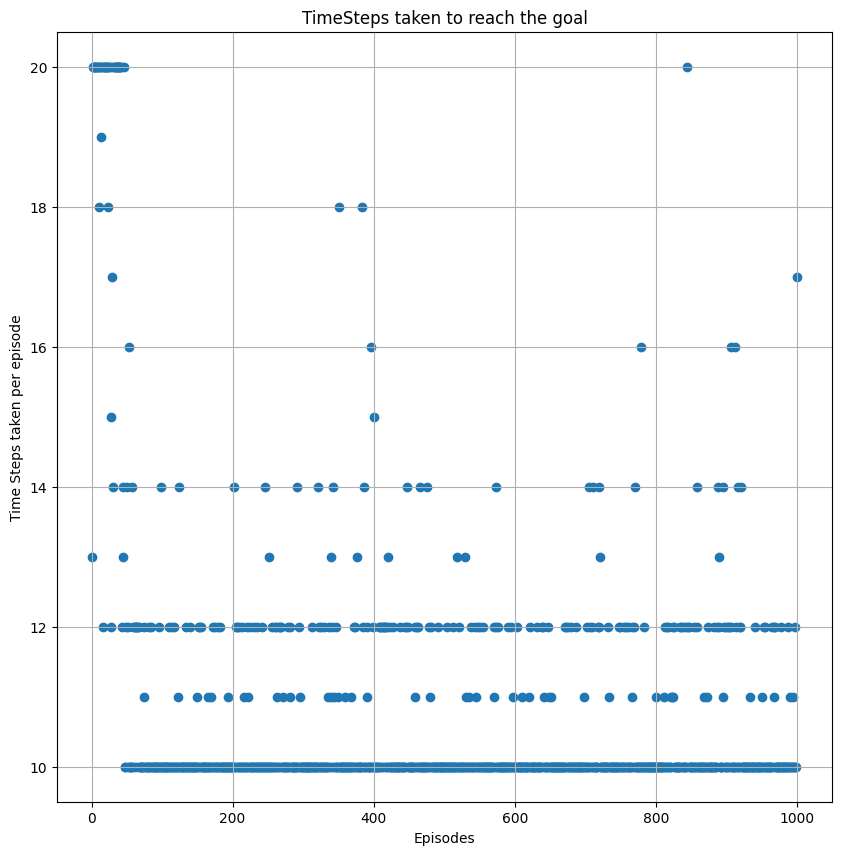

In [29]:
plot_different_graphs(statistics_per_episode4, timesteps_per_episode4)

## Setup 5:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| **0.9995** | 0.04 | 20 | 1000 |

In [30]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 20
alpha = 0.1
gamma = 0.9995
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode5, final_epsilon5, q_learning_table5, timesteps_per_episode5, abs_final_cumulative_reward5 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.9552
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.916992
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.88031232
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.8450998272
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.811295834112
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.77884400074752
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.7476902407176192
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.7177826310889145
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6890713258453579
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.6615084728115436
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.6350481338990819
----Starting Episode  13 ----
Agent has Reached Goal
New Epsilo

In [31]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward5, 2)}")

Absolute total cumulative reward achived in 1000: 101919.28


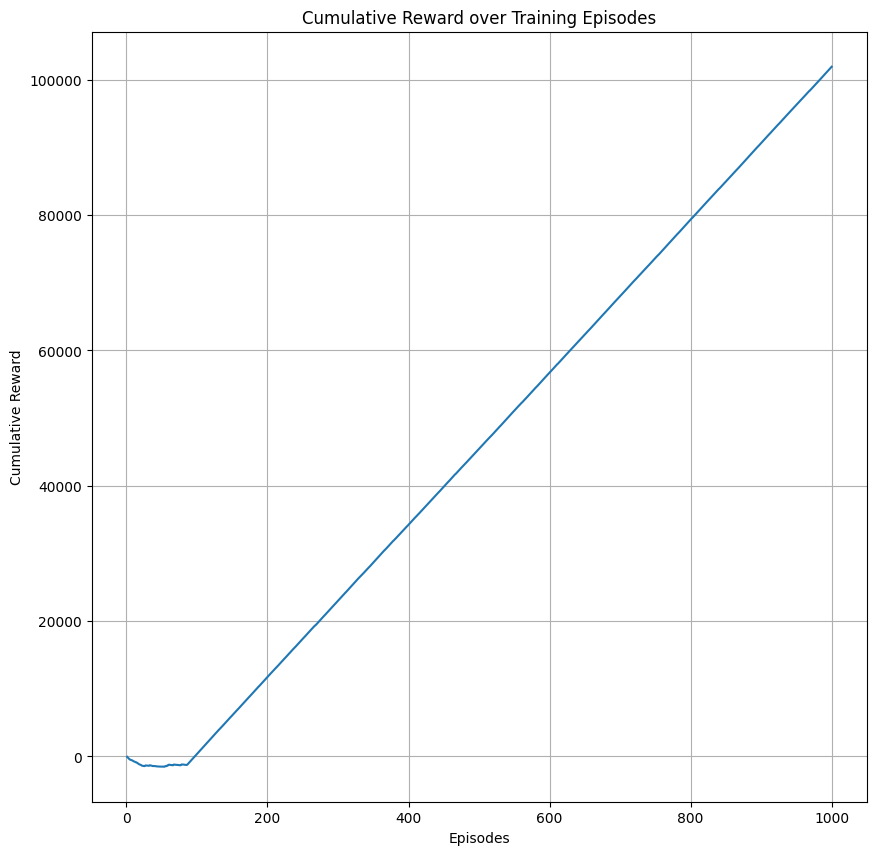

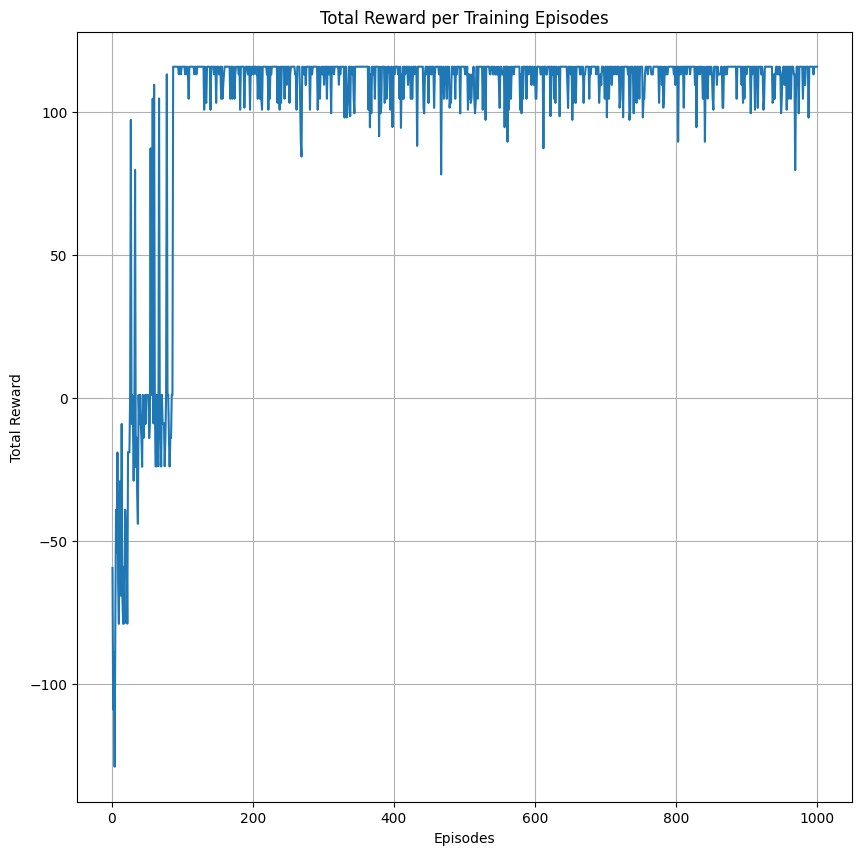

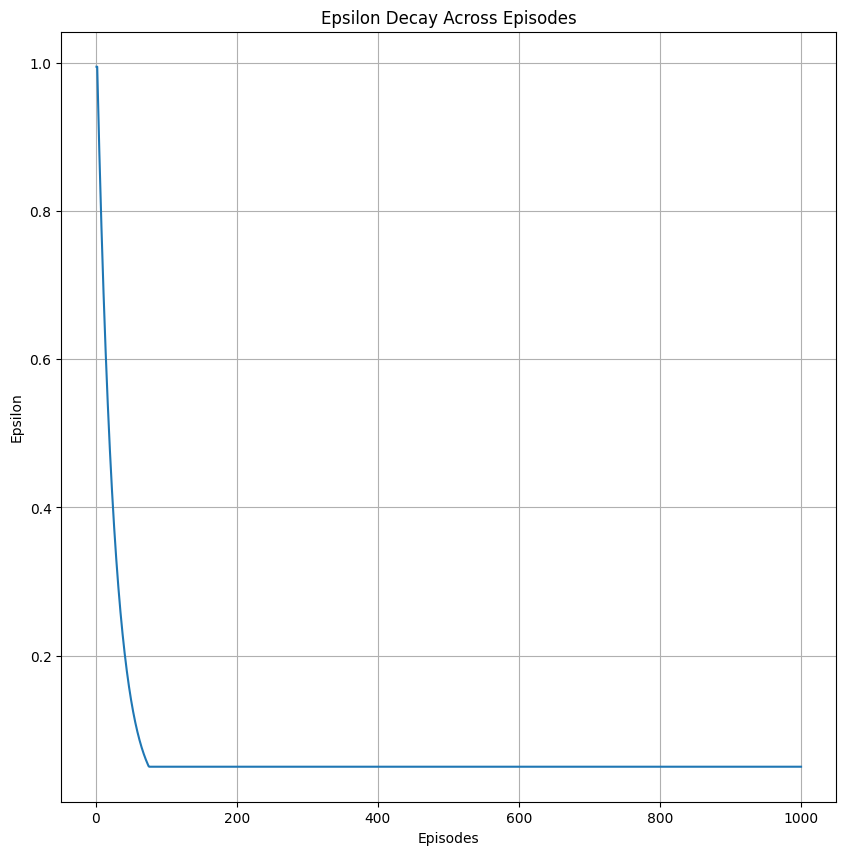

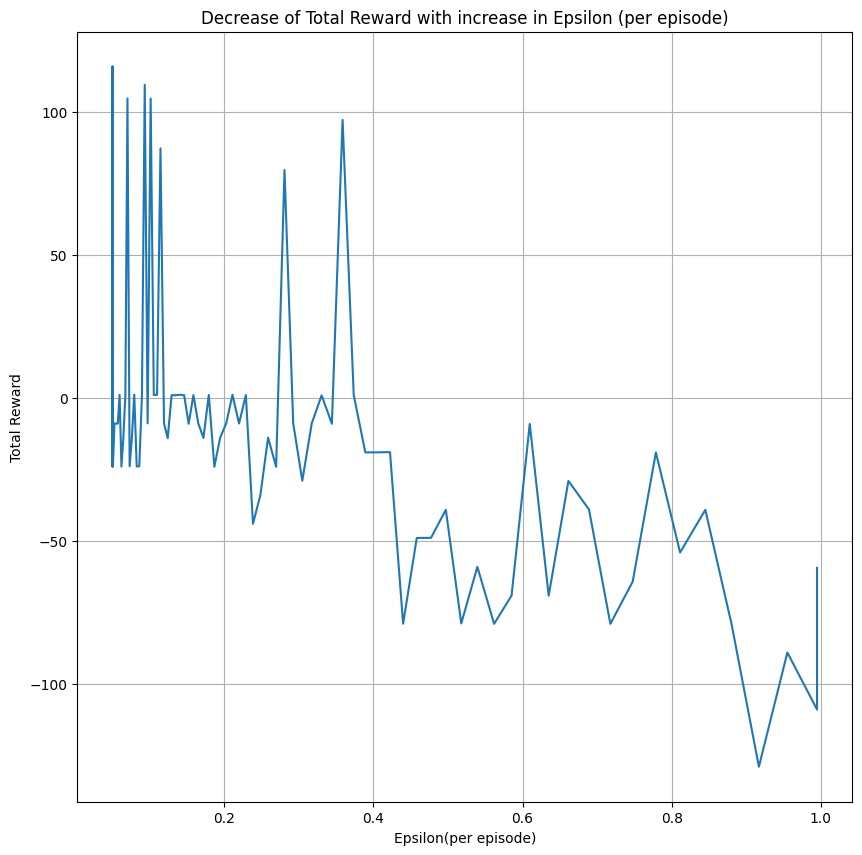

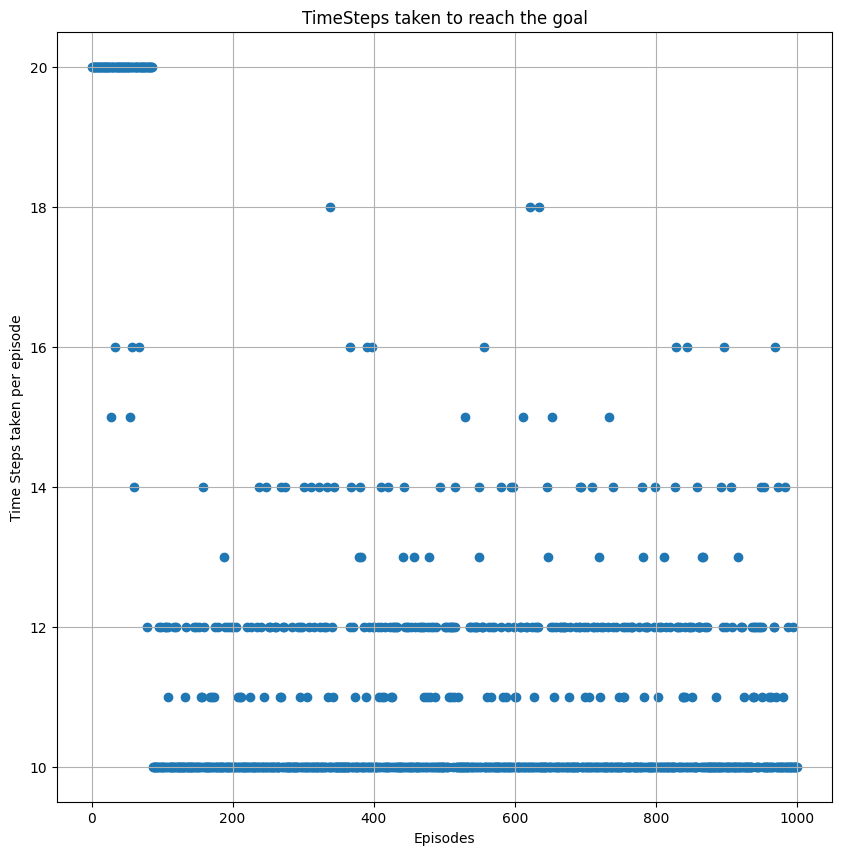

In [32]:
plot_different_graphs(statistics_per_episode5, timesteps_per_episode5)

## Setup 6:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| 0.4 | 0.04 | **11** | 1000 |

In [33]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 11
alpha = 0.1
gamma = 0.4
ep_decay = 0.05

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode6, final_epsilon6, q_learning_table6, timesteps_per_episode6, abs_final_cumulative_reward6 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.94525
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.8979875
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.8530881250000001
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.81043371875
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.7699120328125
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.7314164311718749
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.6948456096132812
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.6601033291326172
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6270981626759863
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.595743254542187
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.5659560918150777
----Starting Episode  13 ----
Agent has Reached Go

In [34]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward6, 2)}")

Absolute total cumulative reward achived in 1000: 52108.52


In [35]:
print(len(timesteps_per_episode6))

1000


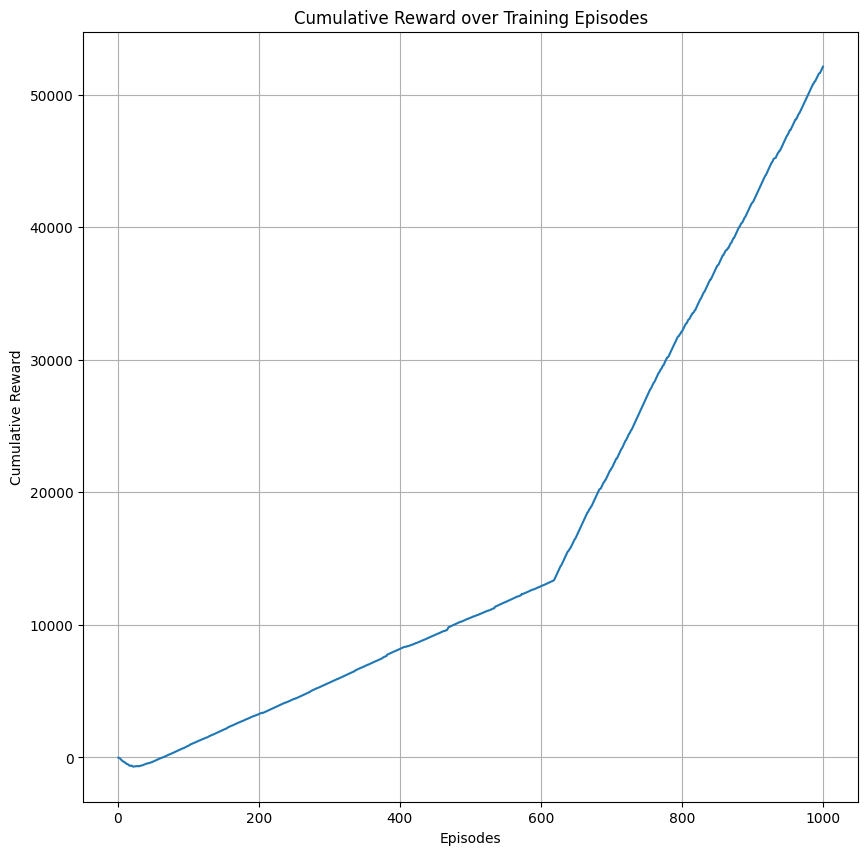

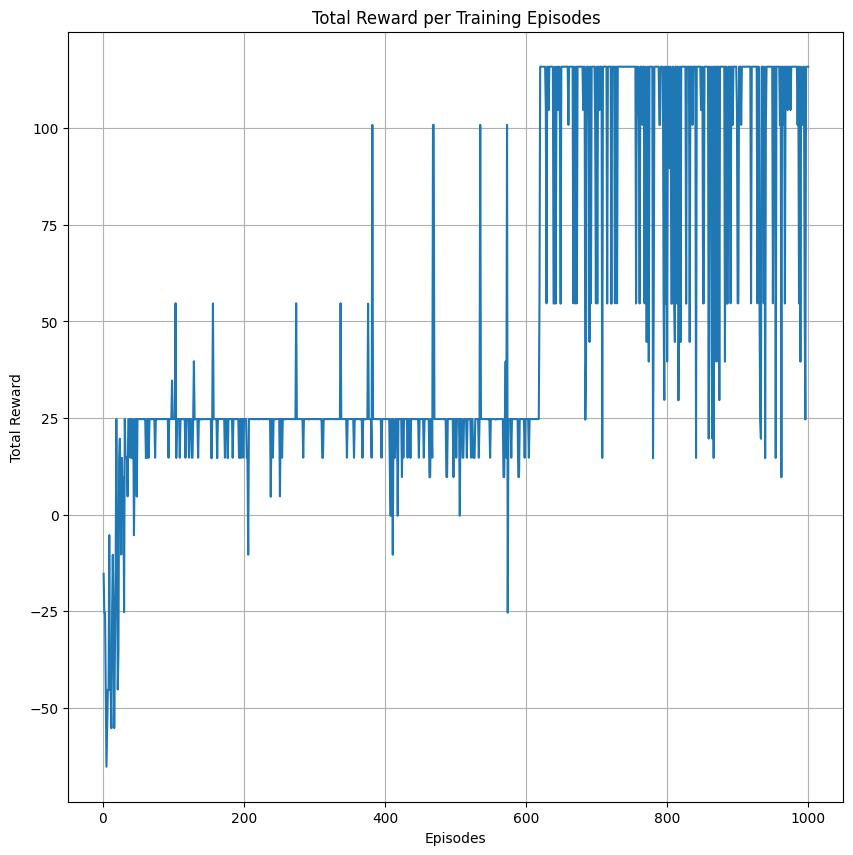

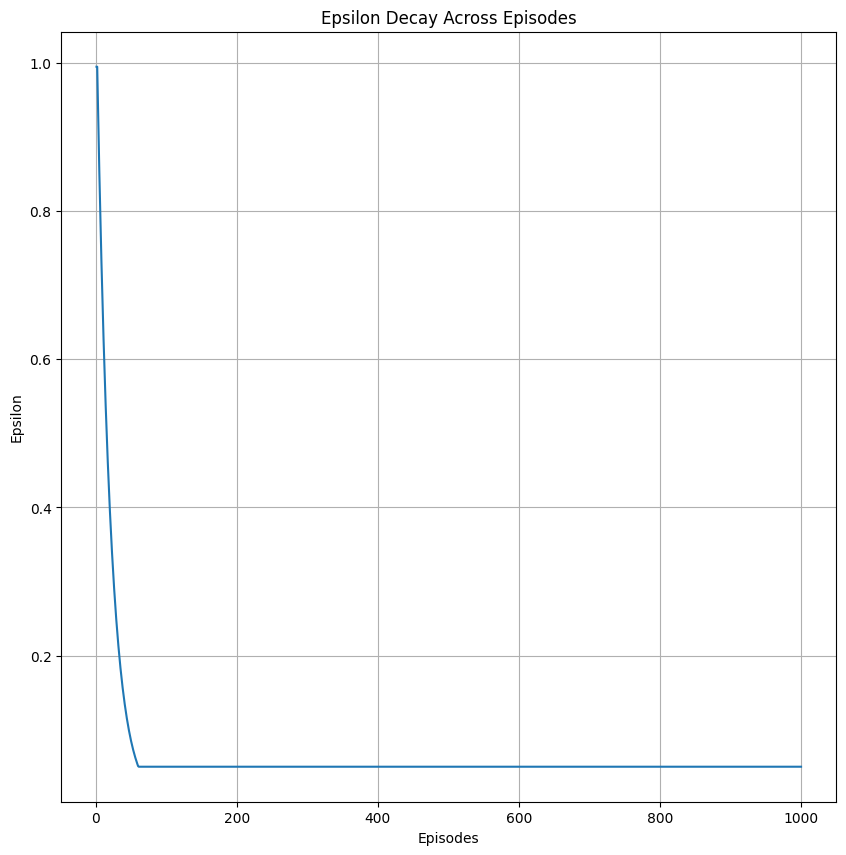

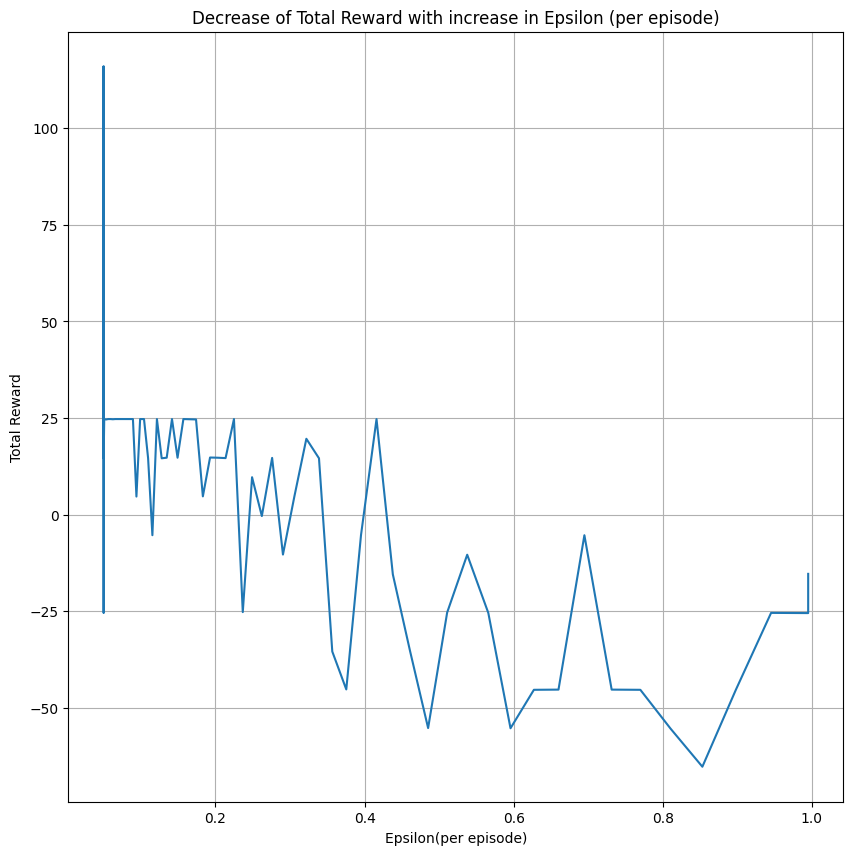

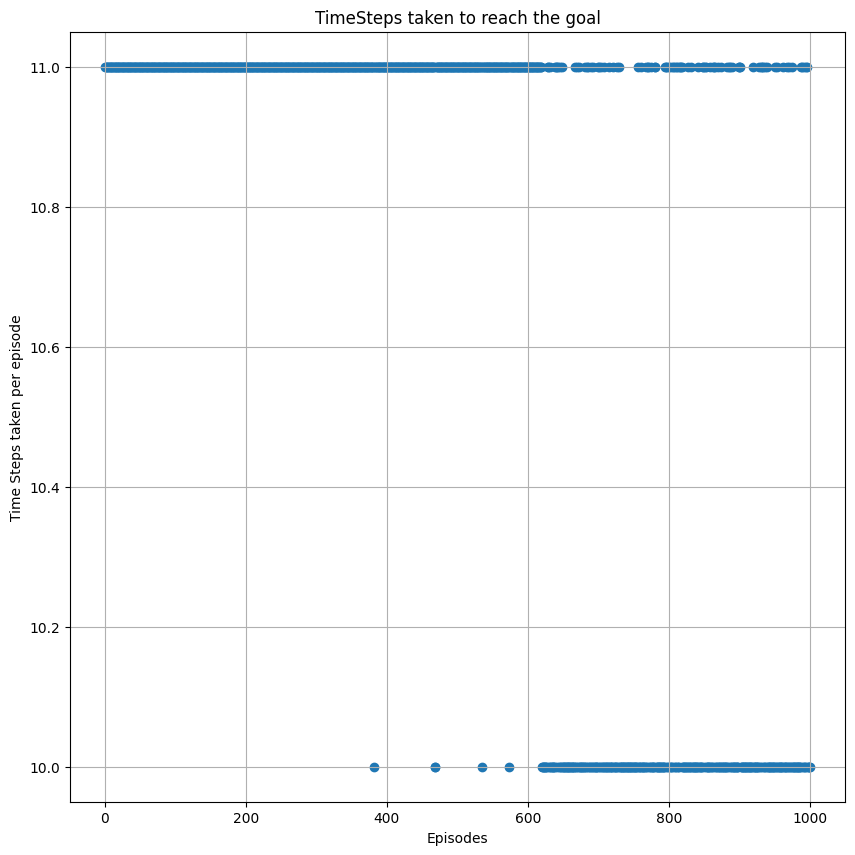

In [36]:
plot_different_graphs(statistics_per_episode6, timesteps_per_episode6)

## Setup 7:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| 0.4 | 0.04 | **15** | 1000 |

In [37]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 18
alpha = 0.1
gamma = 0.4
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode7, final_epsilon7, q_learning_table7, timesteps_per_episode7, abs_final_cumulative_reward7 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.9552
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.916992
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.88031232
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.8450998272
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.811295834112
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.77884400074752
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.7476902407176192
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.7177826310889145
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6890713258453579
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.6615084728115436
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.6350481338990819
----Starting Episode  13 ----
Agent has Reached Goal
New Epsilo

In [38]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward7, 2)}")

Absolute total cumulative reward achived in 1000: 106511.41


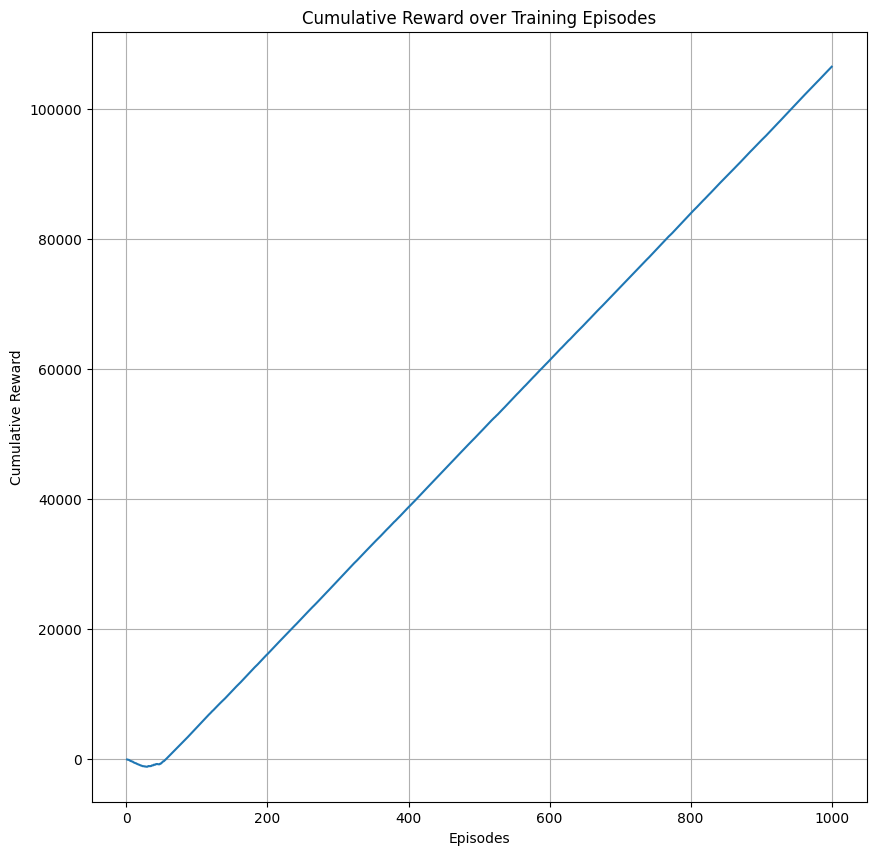

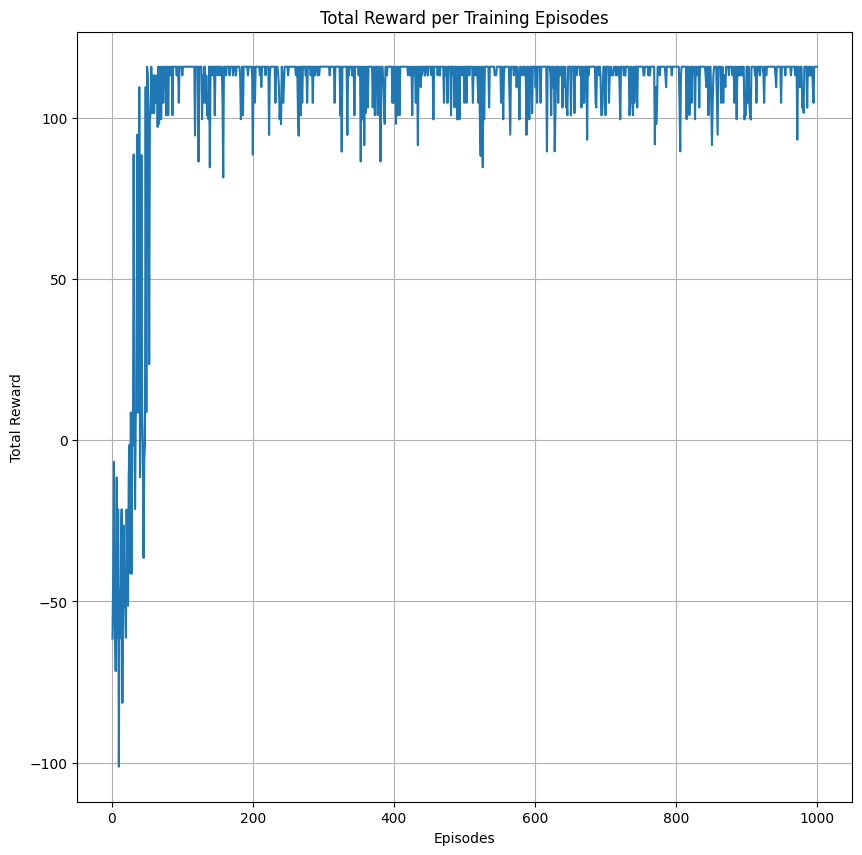

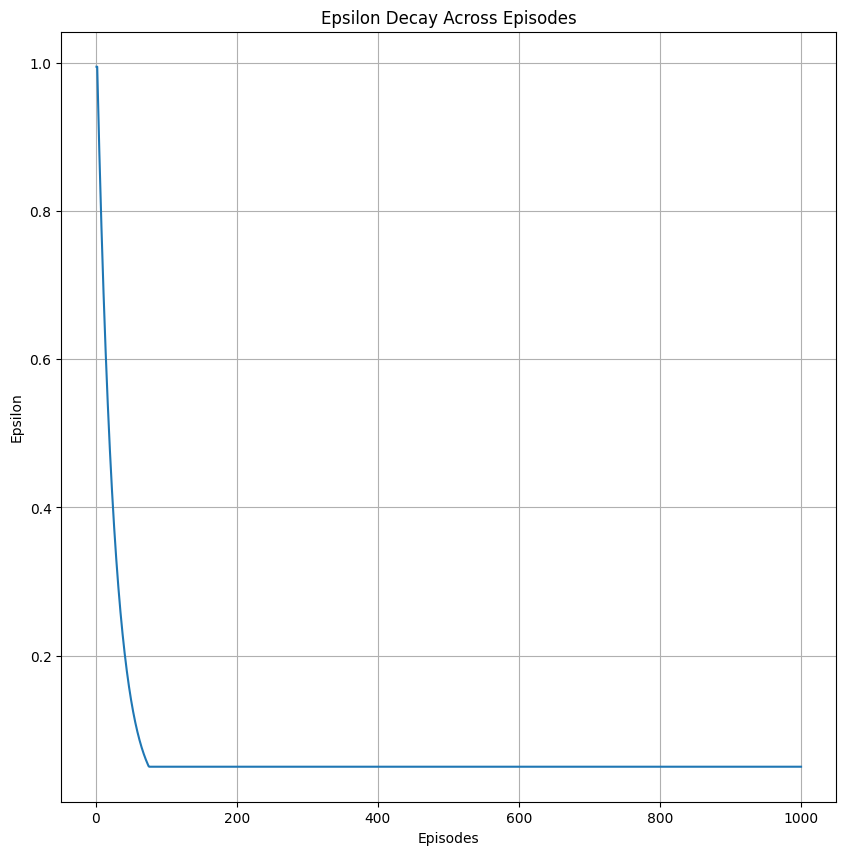

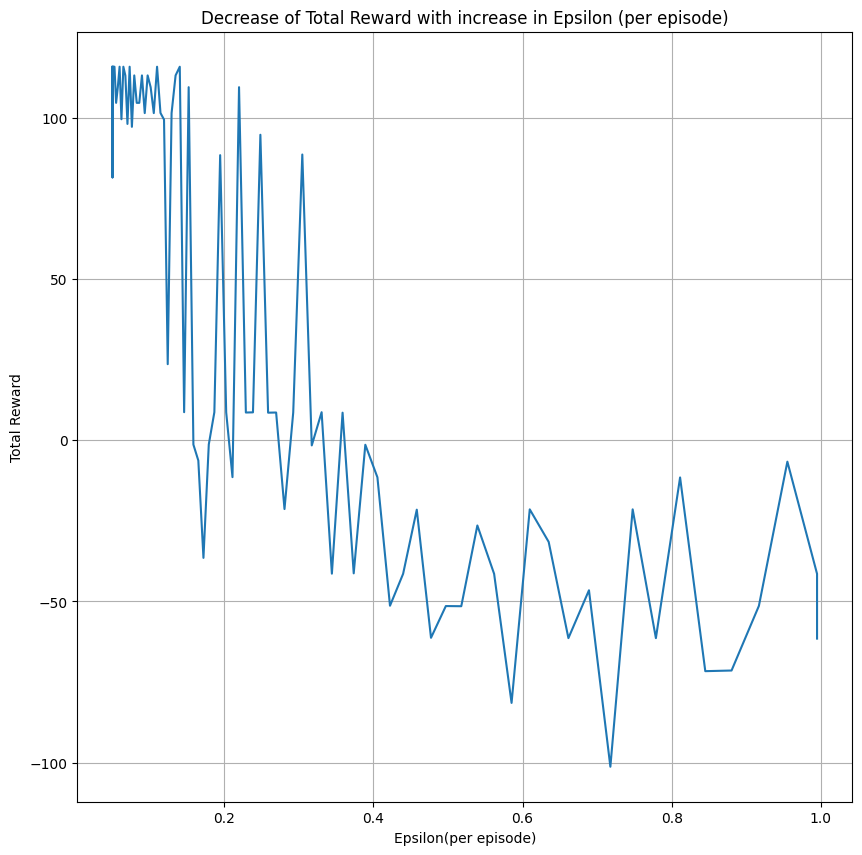

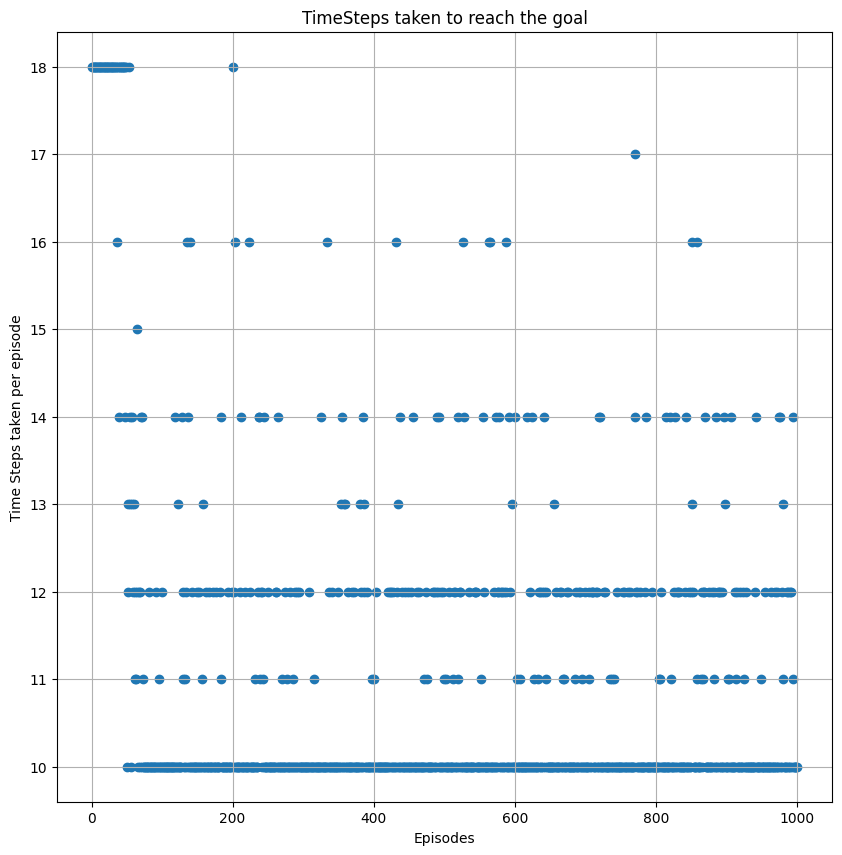

In [39]:
plot_different_graphs(statistics_per_episode7, timesteps_per_episode7)

## Setup 8:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | No. of Episodes |
| :---: | :---: | :---: | :---: |
| 0.4 | 0.04 | **30** | 1000 |

In [40]:
#Defining the parameters
epsilon = 0.995
total_episodes = 1000
maximum_steps = 30
alpha = 0.1
gamma = 0.4
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode8, final_epsilon8, q_learning_table8, timesteps_per_episode8, abs_final_cumulative_reward8 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.9552
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.916992
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.88031232
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.8450998272
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.811295834112
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.77884400074752
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.7476902407176192
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.7177826310889145
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6890713258453579
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.6615084728115436
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.6350481338990819
----Starting Episode  13 ----
Agent has Reached Goal
New Epsilo

In [41]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward8, 2)}")

Absolute total cumulative reward achived in 1000: 93609.37


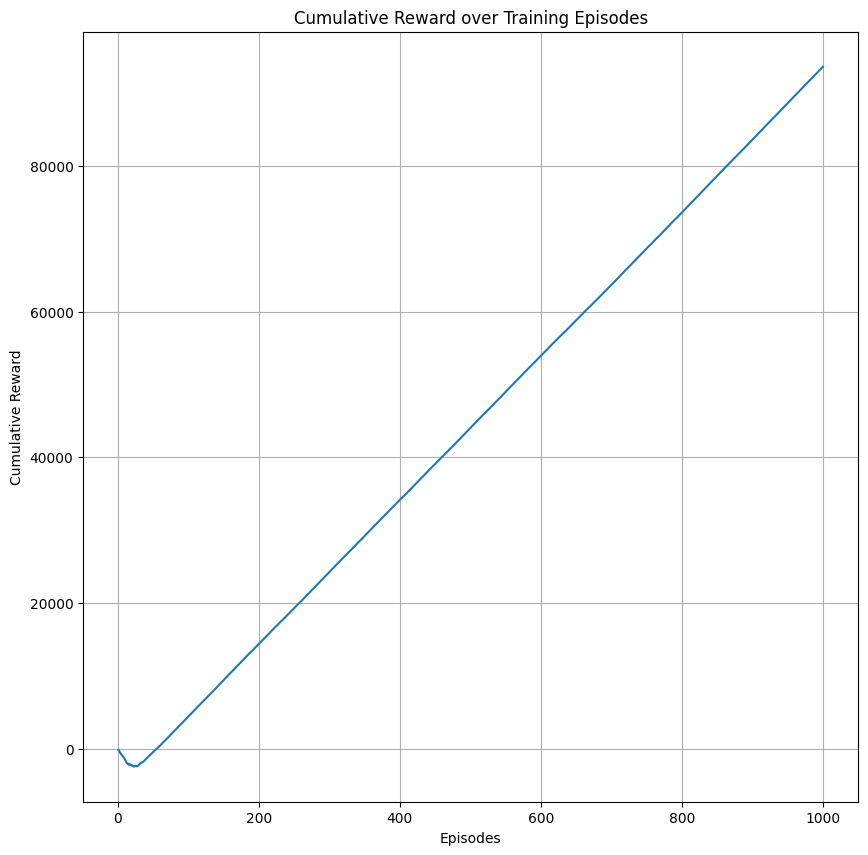

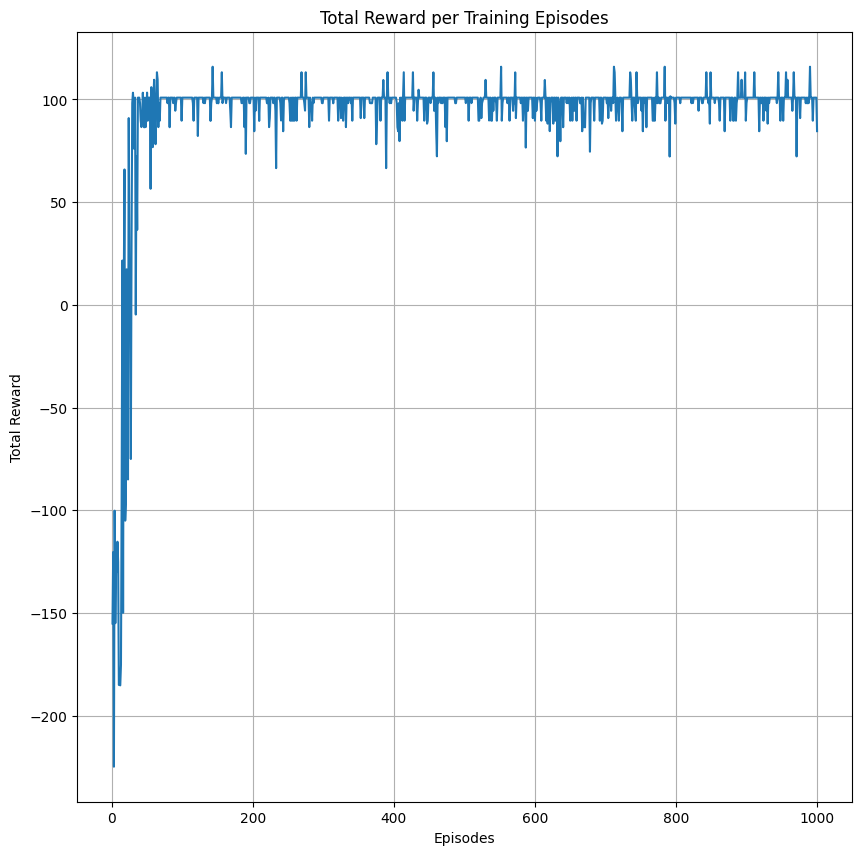

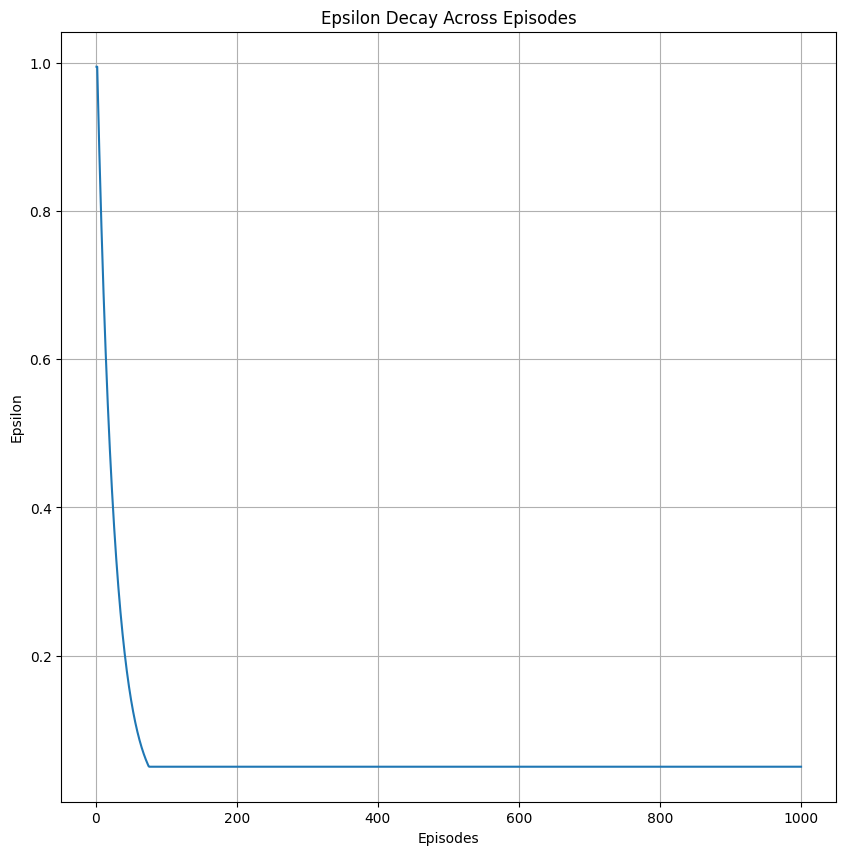

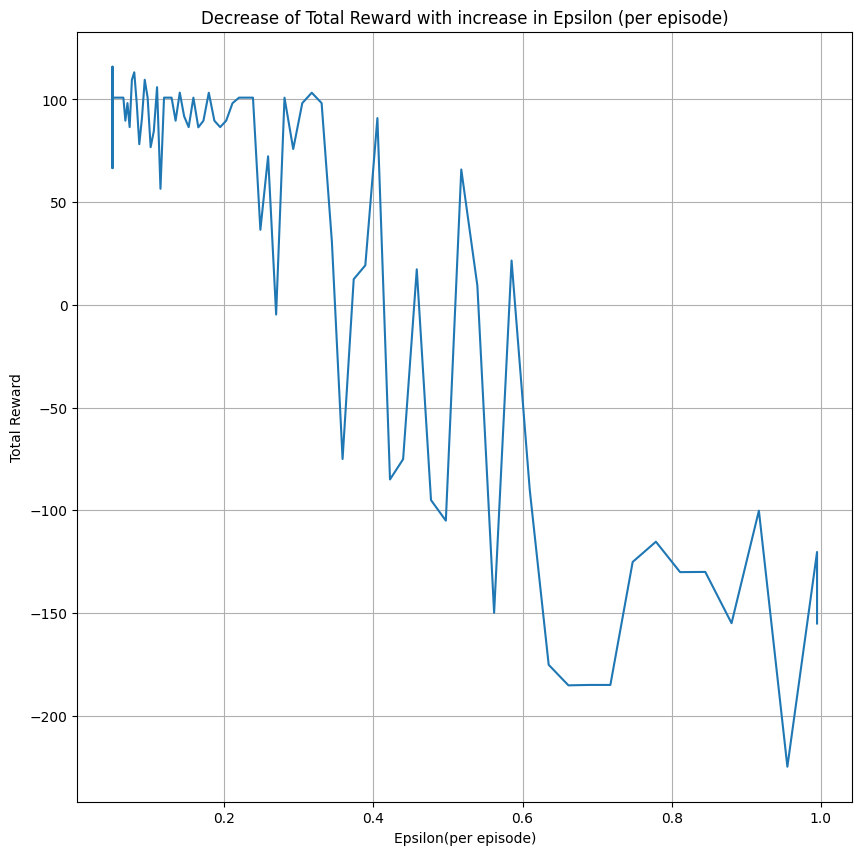

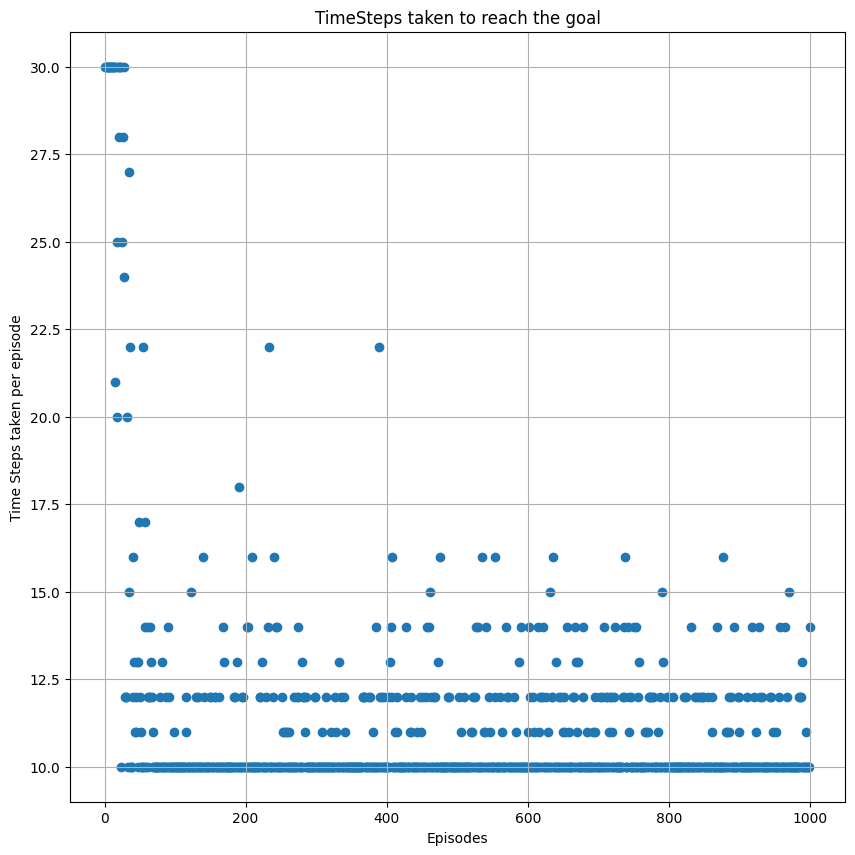

In [42]:
plot_different_graphs(statistics_per_episode8, timesteps_per_episode8)

## Setup 9:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | Epsilon |
| :---: | :---: | :---: | :---: |
| 0.6 | 0.04 | 18 | 0.78 |

In [43]:
#Defining the parameters
epsilon = 0.78
total_episodes = 1000
maximum_steps = 18
alpha = 0.1
gamma = 0.6
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode9, final_epsilon9, q_learning_table9, timesteps_per_episode9, abs_final_cumulative_reward9 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.7488
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.718848
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.69009408
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.6624903168
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.6359907041280001
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.61055107596288
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.5861290329243648
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.5626838716073902
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.5401765167430946
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.5185694560733709
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.49782667783043605
----Starting Episode  13 ----
Agent has Reached Goal
New E

In [44]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward9, 2)}")

Absolute total cumulative reward achived in 1000: 107986.86


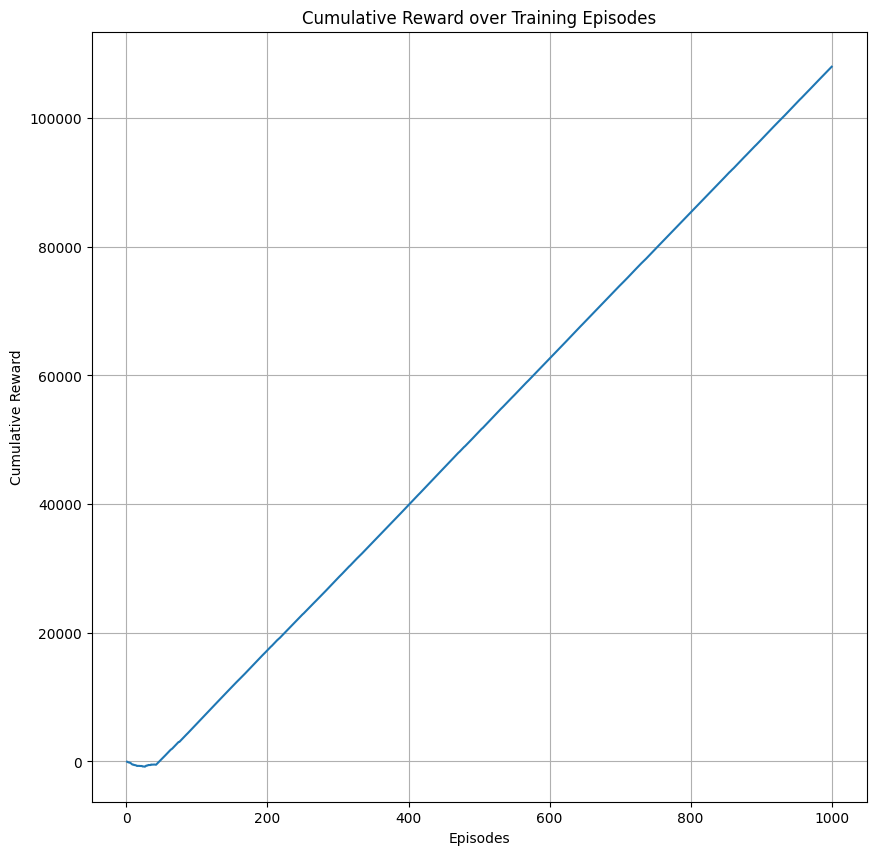

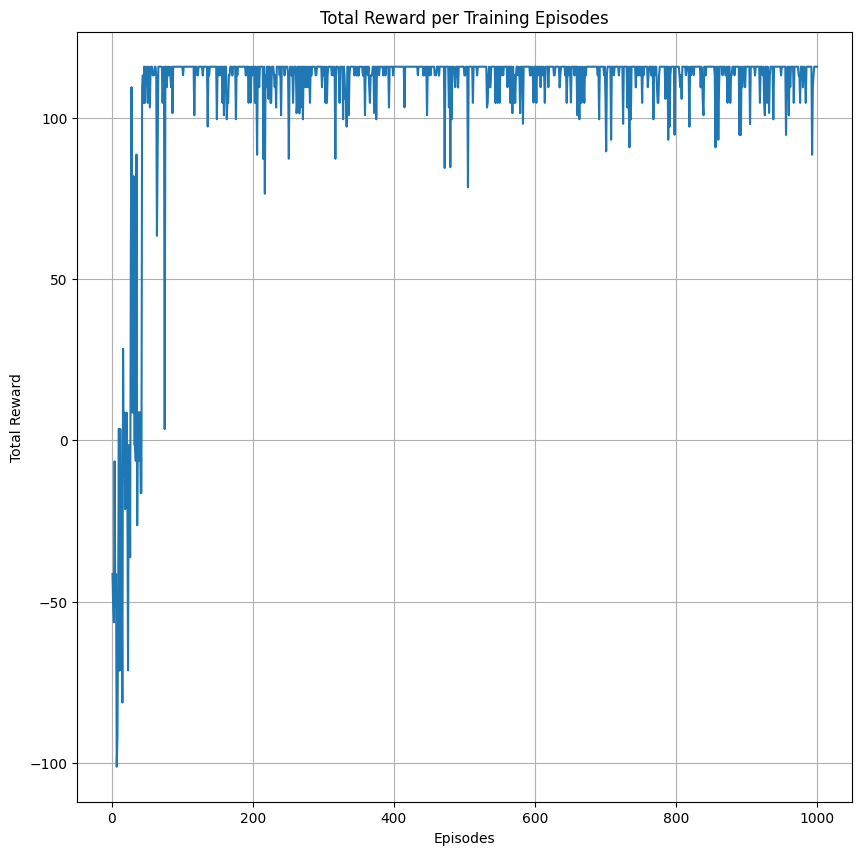

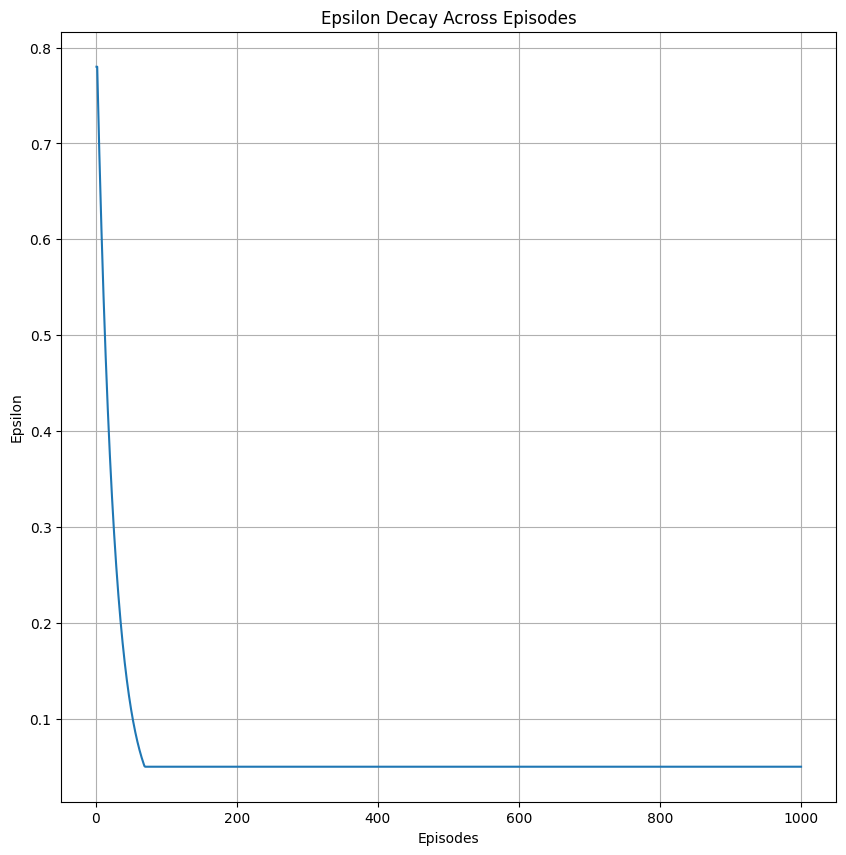

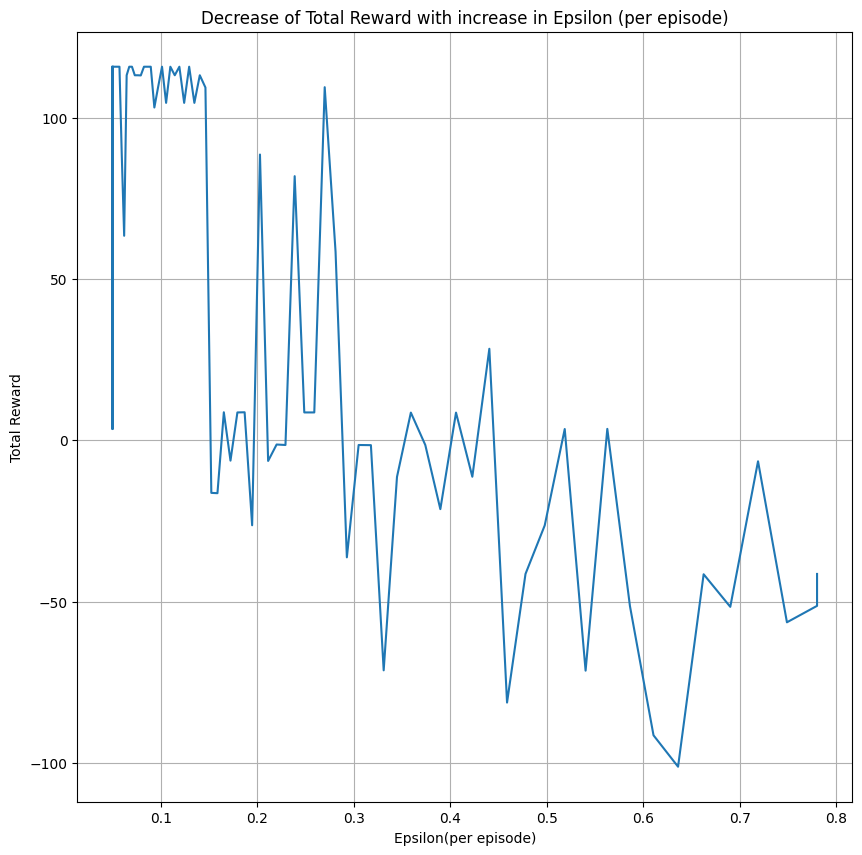

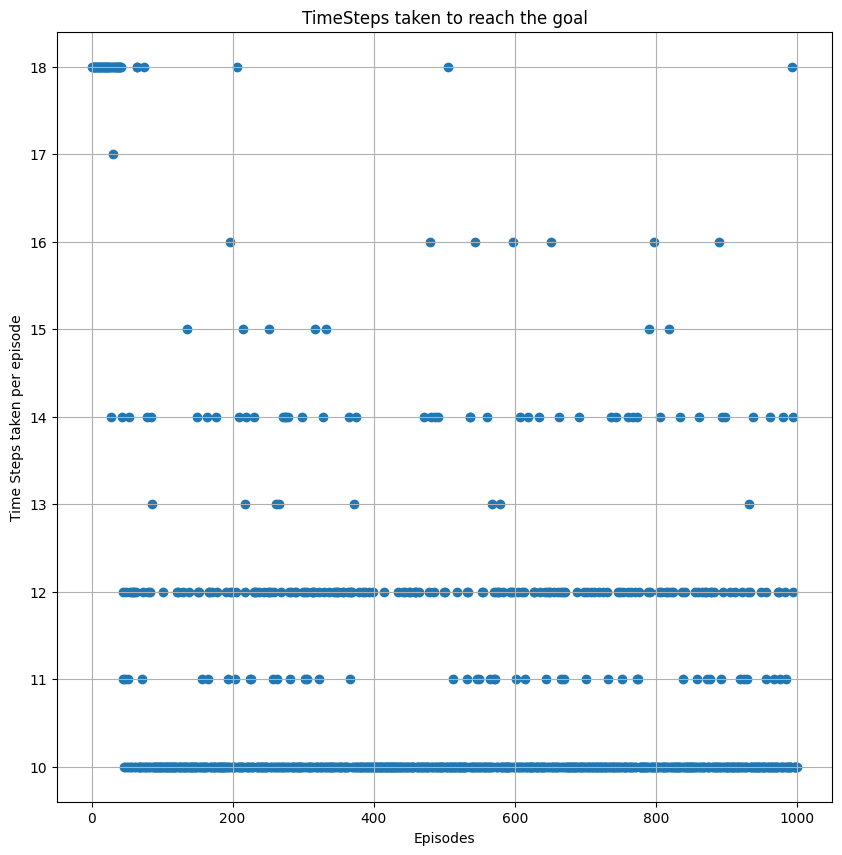

In [45]:
plot_different_graphs(statistics_per_episode9, timesteps_per_episode9)

## Setup 10:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | Epsilon |
| :---: | :---: | :---: | :---: |
| 0.6 | 0.04 | 18 | **0.89** |

In [46]:
#Defining the parameters
epsilon = 0.89
total_episodes = 1000
maximum_steps = 18
alpha = 0.1
gamma = 0.6
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode10, final_epsilon10, q_learning_table10, timesteps_per_episode10, abs_final_cumulative_reward10 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.8544
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.8202240000000001
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.7874150400000001
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.7559184384000001
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.7256817008640001
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.6966544328294401
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.6687882555162624
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.642036725295612
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6163552562837875
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.591701046032436
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.5680330041911386
----Starting Episode  13 ----
Agent

In [47]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward10, 2)}")

Absolute total cumulative reward achived in 1000: 104143.73


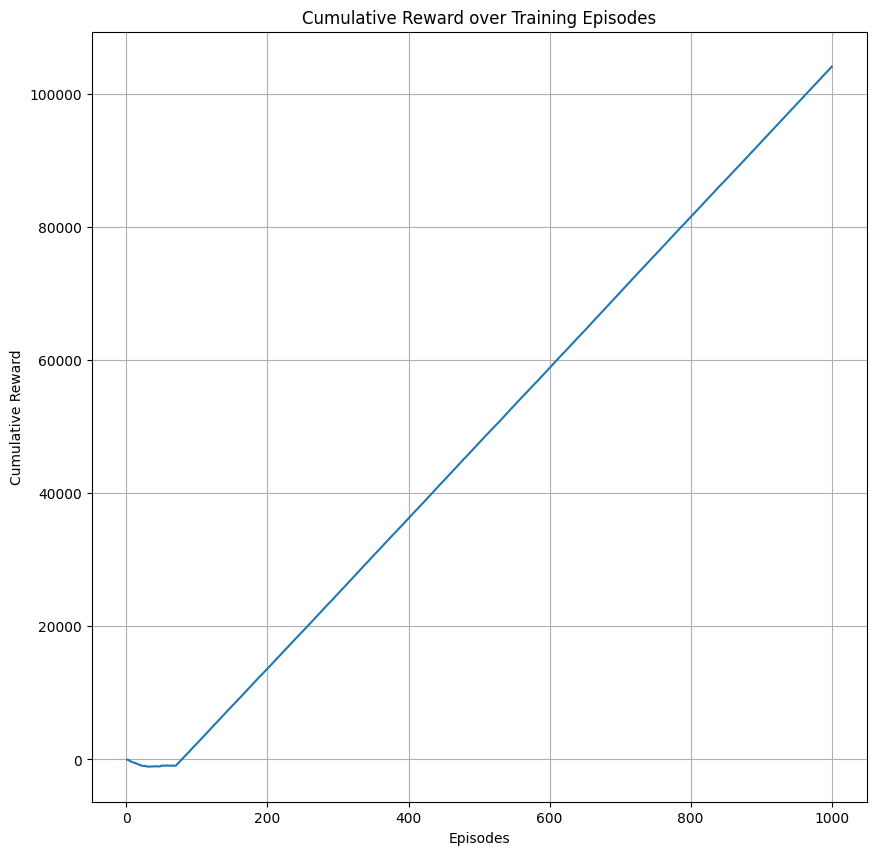

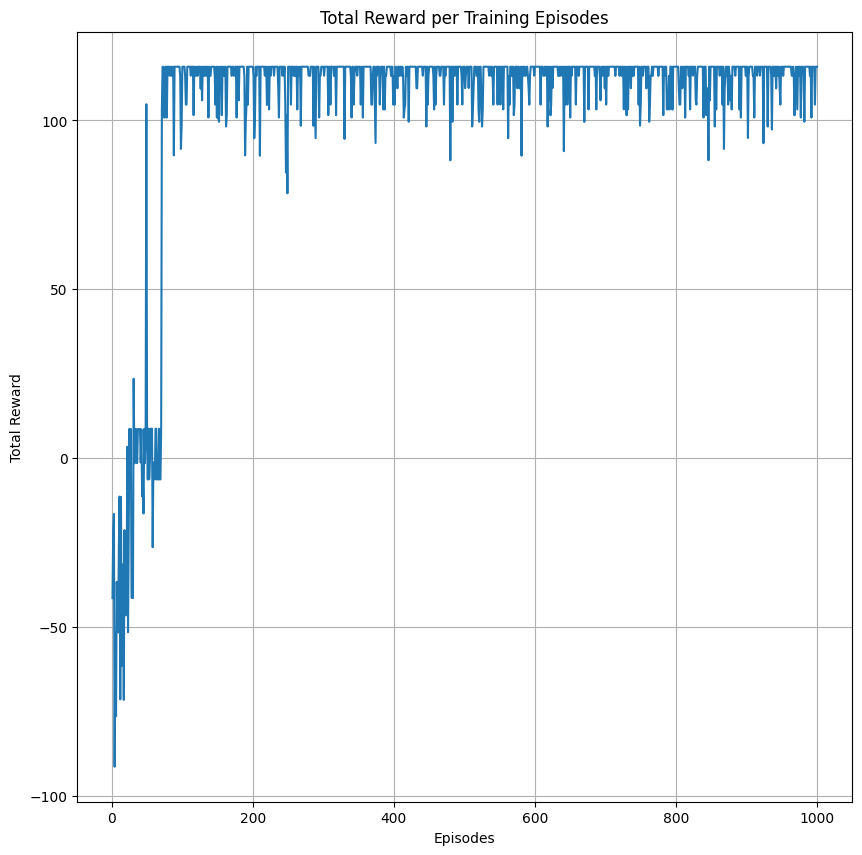

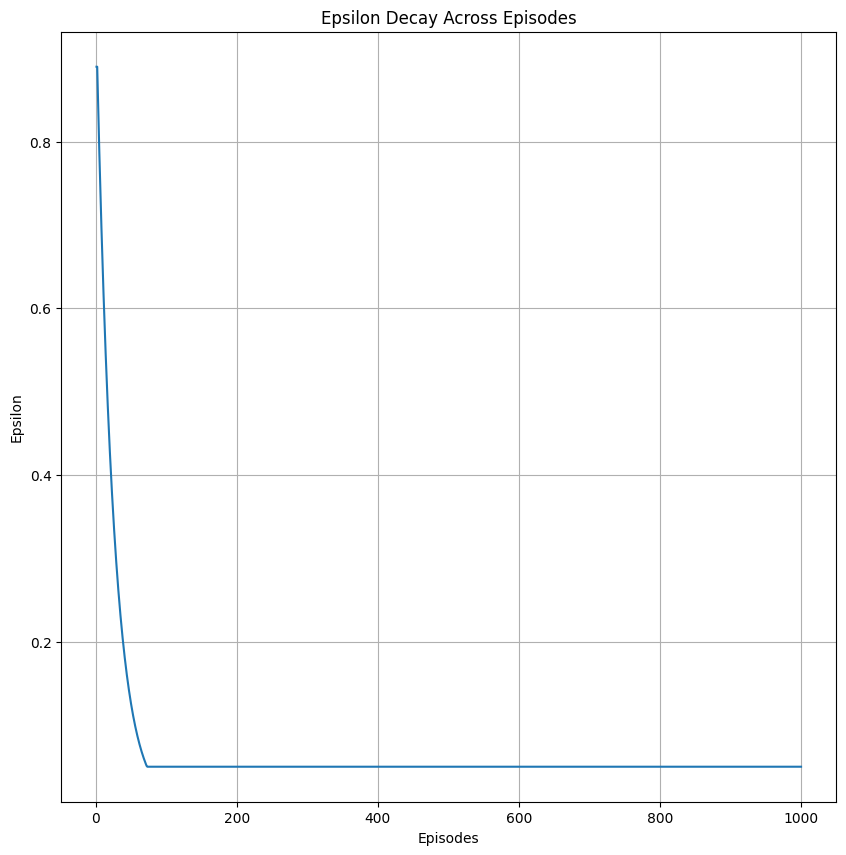

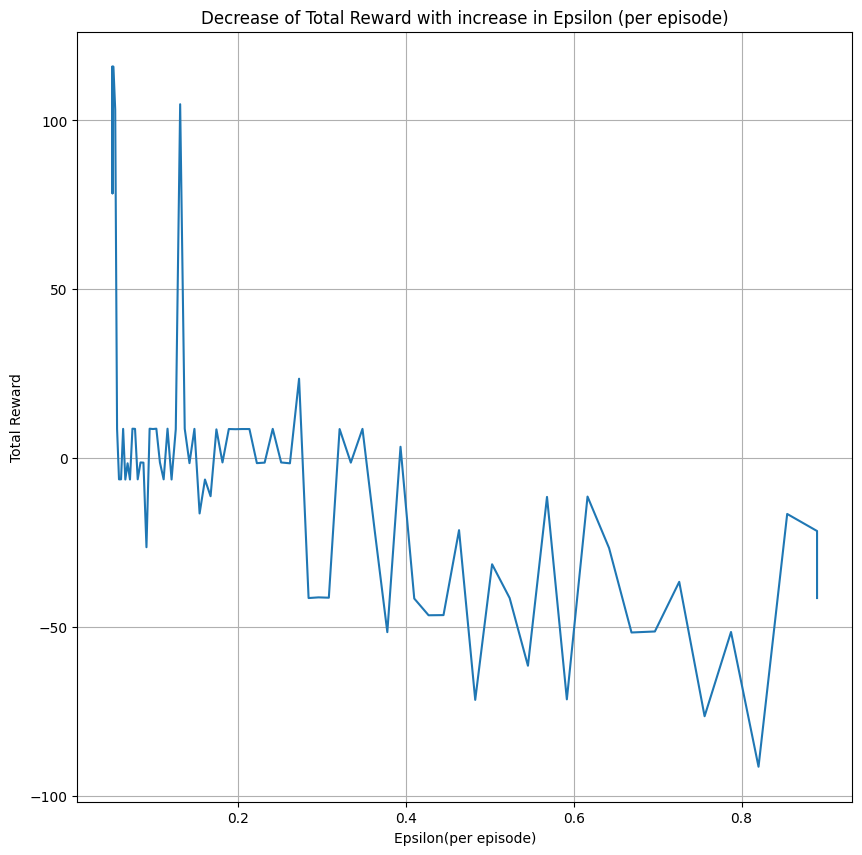

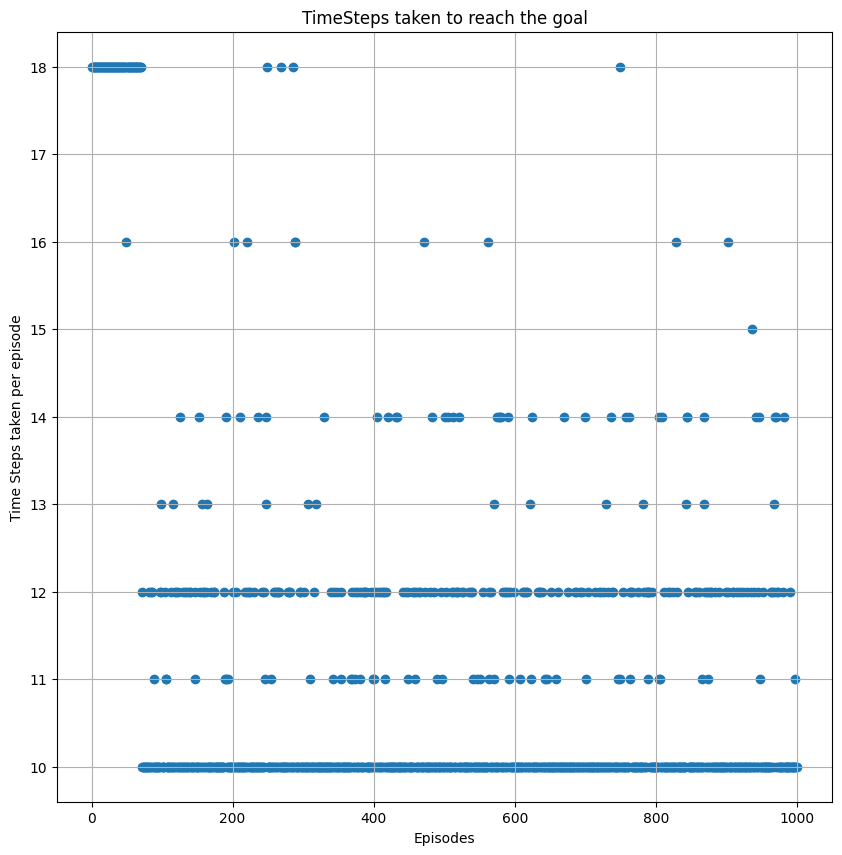

In [48]:
plot_different_graphs(statistics_per_episode10, timesteps_per_episode10)

## Setup 11:

| Discount Factor | Epsilon Decay Rate | Max Timesteps | Epsilon |
| :---: | :---: | :---: | :---: |
| 0.6 | 0.04 | 18 | **0.9999** |

In [49]:
#Defining the parameters
epsilon = 0.9999
total_episodes = 1000
maximum_steps = 20
alpha = 0.1
gamma = 0.6
ep_decay = 0.04

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode11, final_epsilon11, q_learning_table11, timesteps_per_episode11, abs_final_cumulative_reward11 = QLearningAlgo(env, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay)

----Starting Episode  1 ----
Agent has Reached Goal
----Starting Episode  2 ----
Agent has Reached Goal
New Epsilon: 0.959904
----Starting Episode  3 ----
Agent has Reached Goal
New Epsilon: 0.92150784
----Starting Episode  4 ----
Agent has Reached Goal
New Epsilon: 0.8846475264
----Starting Episode  5 ----
Agent has Reached Goal
New Epsilon: 0.849261625344
----Starting Episode  6 ----
Agent has Reached Goal
New Epsilon: 0.81529116033024
----Starting Episode  7 ----
Agent has Reached Goal
New Epsilon: 0.7826795139170304
----Starting Episode  8 ----
Agent has Reached Goal
New Epsilon: 0.7513723333603491
----Starting Episode  9 ----
Agent has Reached Goal
New Epsilon: 0.7213174400259352
----Starting Episode  10 ----
Agent has Reached Goal
New Epsilon: 0.6924647424248979
----Starting Episode  11 ----
Agent has Reached Goal
New Epsilon: 0.664766152727902
----Starting Episode  12 ----
Agent has Reached Goal
New Epsilon: 0.6381755066187859
----Starting Episode  13 ----
Agent has Reached Goal

In [50]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward11, 2)}")

Absolute total cumulative reward achived in 1000: 105681.47


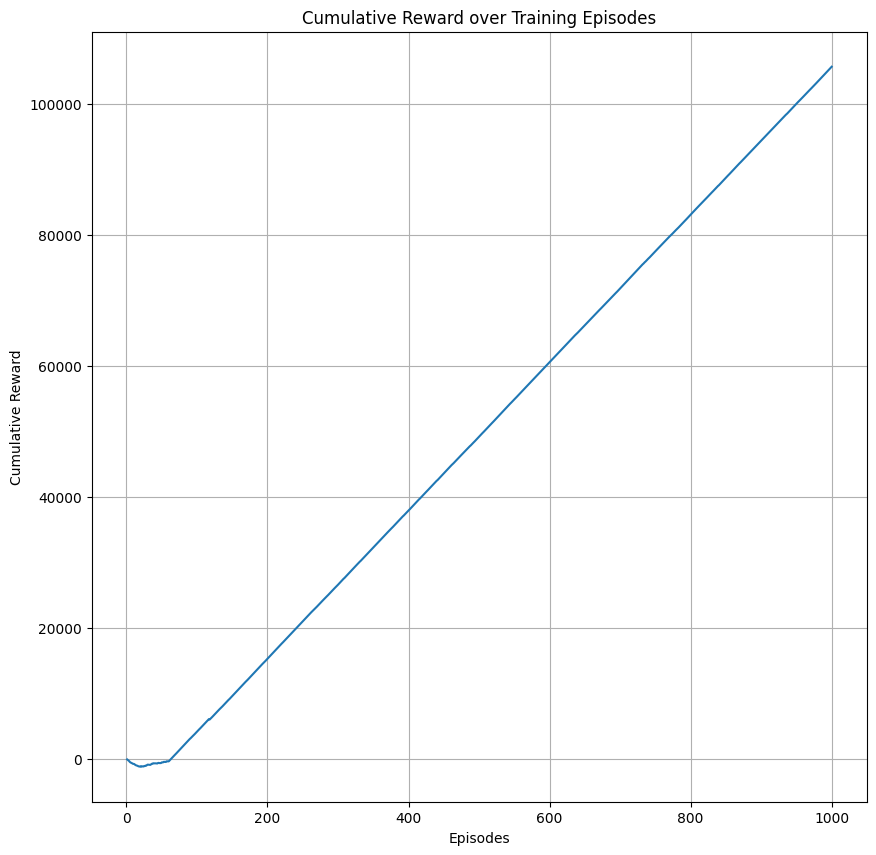

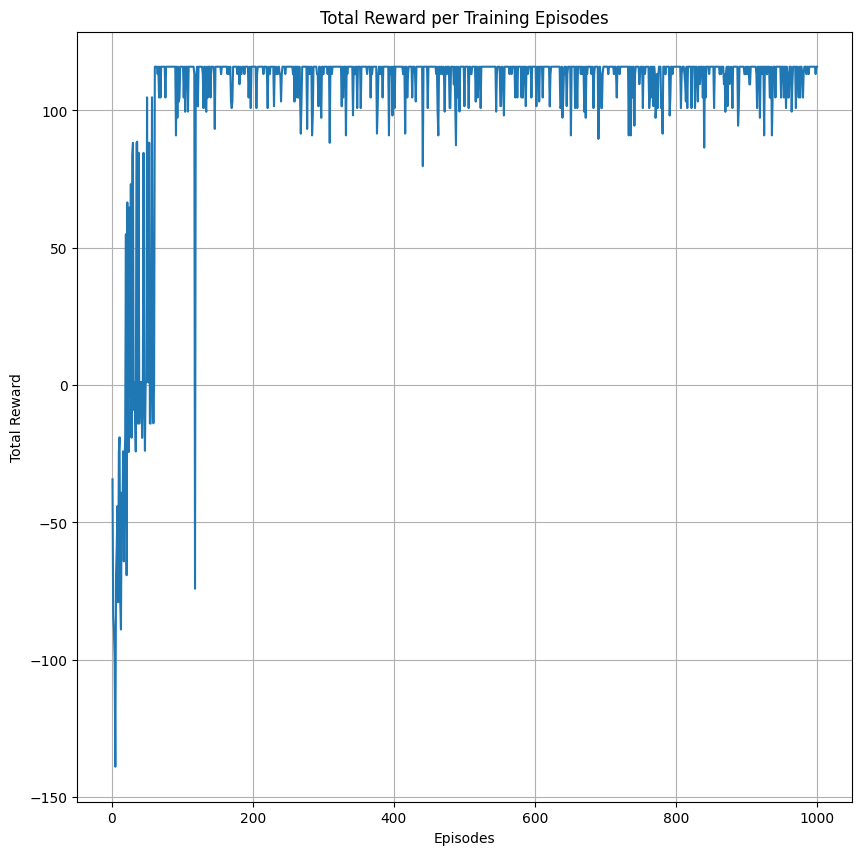

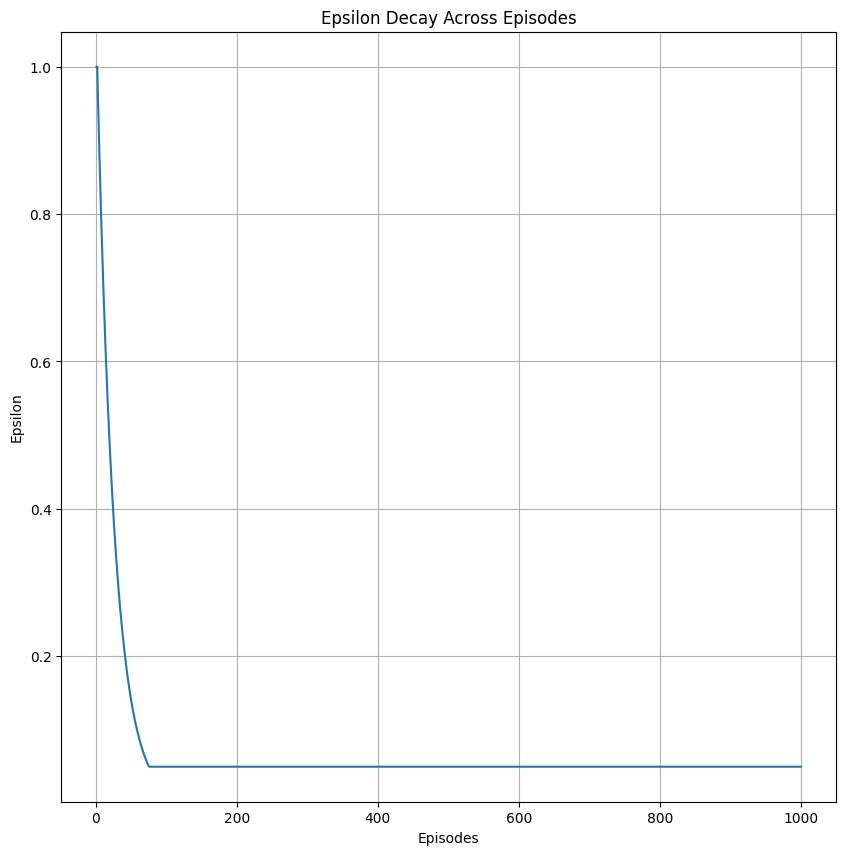

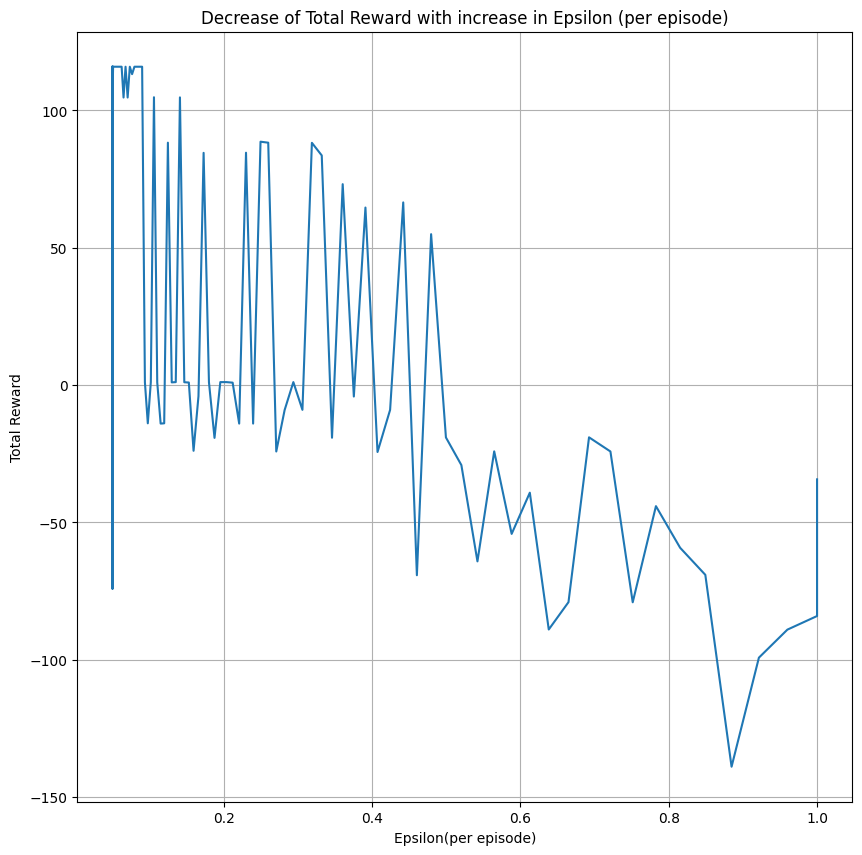

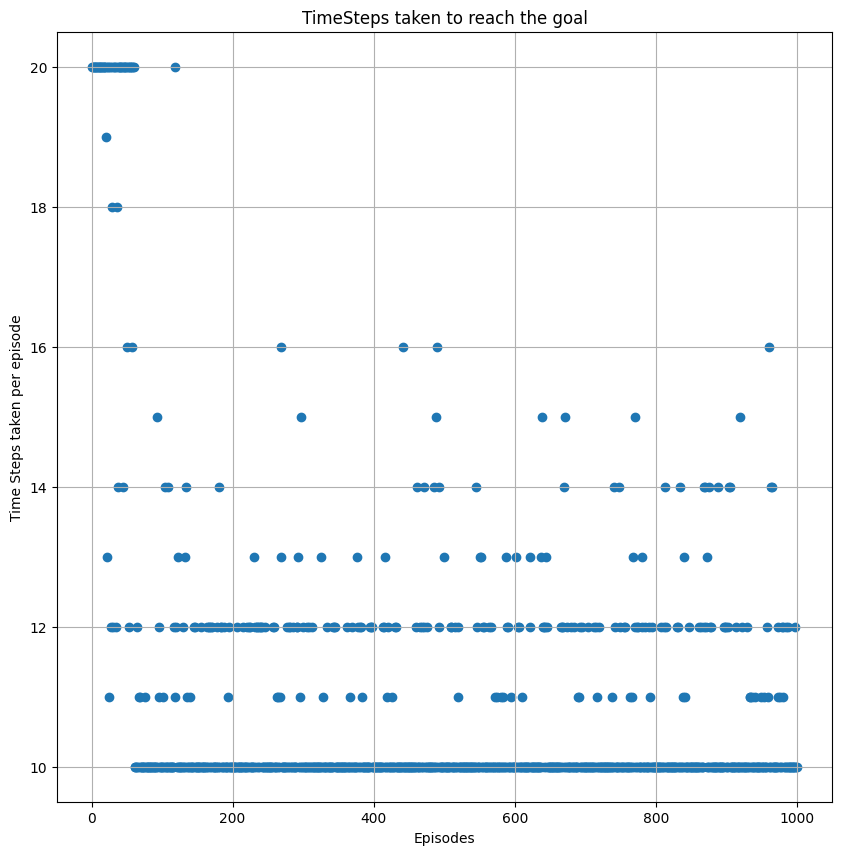

In [51]:
plot_different_graphs(statistics_per_episode11, timesteps_per_episode11)

# Bonus Task: Implementing N-Step SARSA

#### Reference for the (formula for table updation) N-Step SARSA Algorithm was taken from the following link:
- https://towardsdatascience.com/introduction-to-reinforcement-learning-rl-part-7-n-step-bootstrapping-6c3006a13265

In [52]:
def chooseActionSARSA(q_learning_table, state, epsilon):
    if np.random.uniform(0, 1) >= epsilon: # greedy
      action = np.argmax(q_learning_table[state, :])

      print("Action chosen: ", action)
    else: # random
      action = env.action_space.sample()
        
    return action

In [53]:
def nStepSarsa(env, n, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay=0.01):
    # Initializing variables
    decay_counter = 0.001 * total_episodes
    decay_factor = ep_decay
    cumulative_reward = 0
    successful_episodes = []
    timesteps_per_episode = []
    statistics_per_episode = {"Episode": [], "Episode_Reward": [], "Cumulative_Reward": [], "Epsilon": []}

    # Initializing the learning table
    sarsa_table = np.zeros((env.observation_space.n, env.action_space.n))

    # Starting the Training of the Model
    for episode in range(total_episodes):
        timeStep = 0
        currentState = env.reset()
        currentAction = chooseActionSARSA(sarsa_table, currentState, epsilon)
        print(sarsa_table)
        episodeReward = 0
        print('----Starting Episode ', episode+1, '----')
        
        # Initialize the n-step buffer with current state, action and reward
        n_step_buffer = [(currentState, currentAction, 0)]
        
        # Initialize T to infinity
        T = float('inf')

        #print("Value of T: ", T)
        
        while True:
            if timeStep < T:
                newState, reward, done, info = env.step(currentAction)
                episodeReward += reward
                cumulative_reward += reward
                
                # Add new state, action, and reward to buffer
                print("N-step buffer updated: add value")
                n_step_buffer.append((newState, chooseActionSARSA(sarsa_table, newState, epsilon), reward))
                print(n_step_buffer)
                
                if done:
                  #print("Done: {} || Timestep: {}".format(done, timestep))
                  T = timeStep + 1
            
            #print("Timestep val: ", timeStep)
            # Update Sarsa values when an n-step transition is reached
            tau = timeStep - n + 1
            if tau >= 0:
                G = 0

                print("if tau>= 0 For loop range: ", range(tau, min(tau + n, T)))
                print(n_step_buffer)

                for i in range(tau, min(tau + n, T)):
                    G += gamma**(i-tau) * n_step_buffer[i][2]
                
                if tau + n < T:
                  
                  #print("Length of n_step_buffer", len(n_step_buffer))
                  #print(n_step_buffer)
                  #print("tau + n:", tau+n)

                  G_x = n_step_buffer[tau + n][0]
                  G_y = n_step_buffer[tau + n][1]
                  G += gamma**n * sarsa_table[G_x][G_y]
                
                state_to_update, action_to_update, _ = n_step_buffer[tau]
                sarsa_table[state_to_update][action_to_update] += alpha * (G - sarsa_table[state_to_update][action_to_update])
            
            currentState = newState
            currentAction = n_step_buffer[tau][1]
            
            # Remove the first element from the buffer after every time step
            #n_step_buffer.pop(0)
            
            timeStep += 1
            
            # Execute if Agent Reaches the Goal State
            if done or timeStep >= maximum_steps:
                print('Agent has Reached Goal')
                successful_episodes.append(episode)
                timesteps_per_episode.append(timeStep)
                break
        
        statistics_per_episode["Episode"].append(episode+1)
        statistics_per_episode["Episode_Reward"].append(episodeReward)
        statistics_per_episode["Cumulative_Reward"].append(cumulative_reward)
        statistics_per_episode["Epsilon"].append(epsilon)
        
        if episode > 0 and episode % decay_counter == 0:
            epsilon -= (epsilon * decay_factor)
            print('New Epsilon:', epsilon)
            
        if epsilon < 0.01:
            epsilon = 0.01
    
    return statistics_per_episode, epsilon, sarsa_table, timesteps_per_episode, cumulative_reward


In [54]:
#Defining the parameters
%%capture captured
epsilon = 0.95
total_episodes = 10000
maximum_steps = 20
alpha = 0.1
gamma = 0.9
ep_decay = 0.05

# N = 2, Hence 2 step SARSA 
#-------
N = 2
#-------

env = GridEnvironment(maximum_steps)
agent = RandomAgent(env)

statistics_per_episode_bonus, final_epsilon_bonus, q_learning_table_bonus, timesteps_per_episode_bonus, abs_final_cumulative_reward_bonus = nStepSarsa(env, N, epsilon, total_episodes, maximum_steps, alpha, gamma, ep_decay=0.01)

In [55]:
print(f"Absolute total cumulative reward achived in {total_episodes}: {round(abs_final_cumulative_reward_bonus, 2)}")

Absolute total cumulative reward achived in 10000: 363614.65


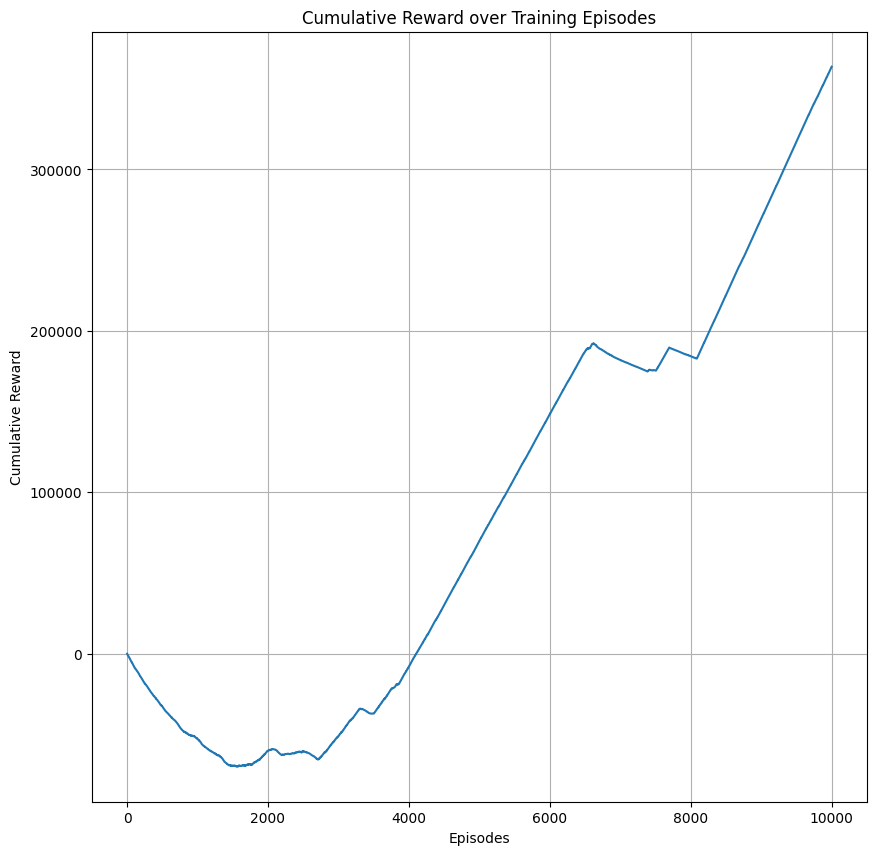

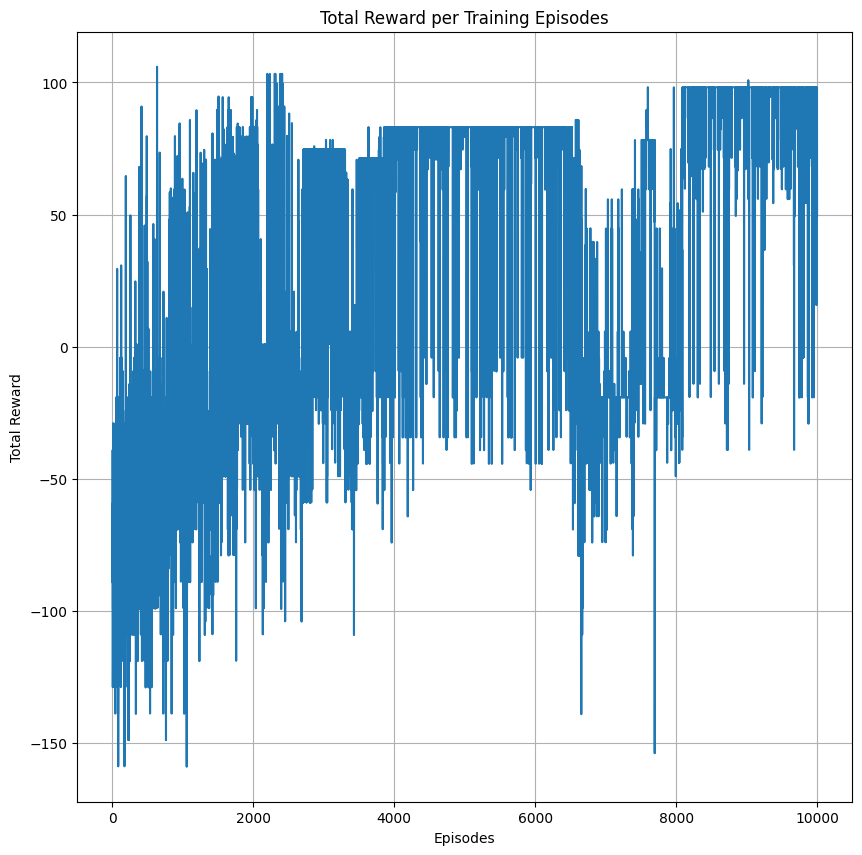

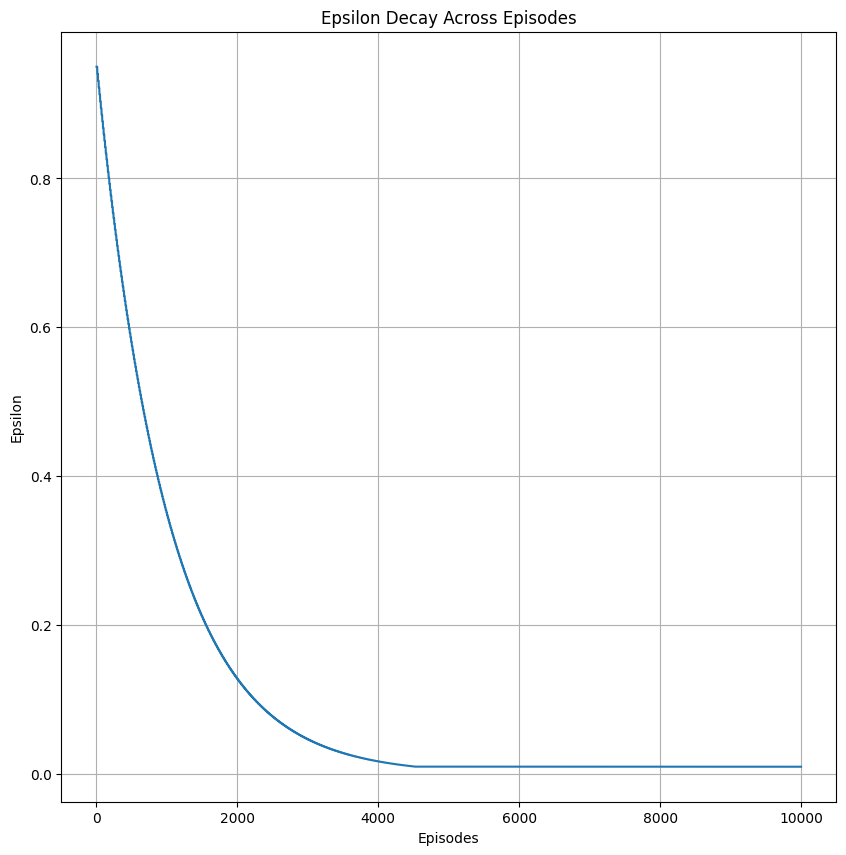

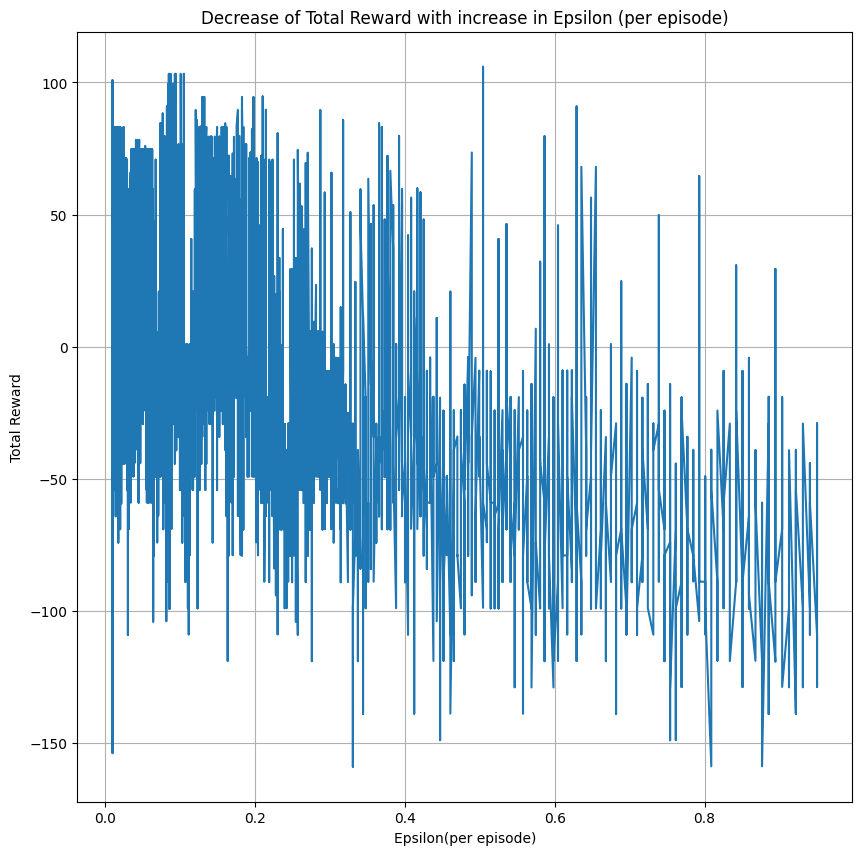

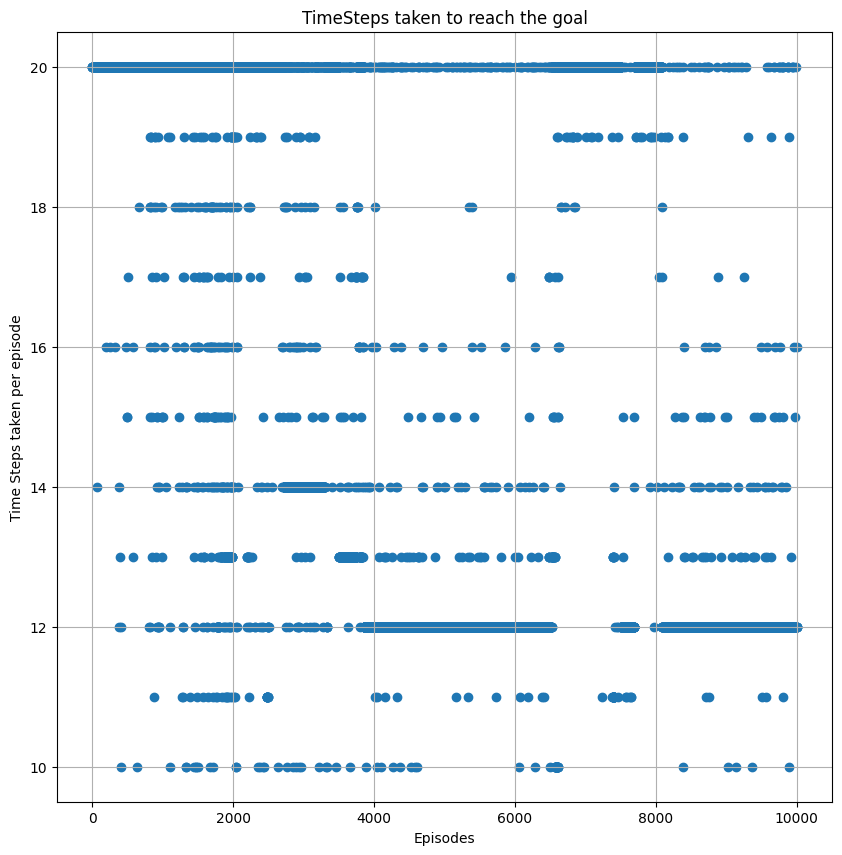

In [56]:
plot_different_graphs(statistics_per_episode_bonus, timesteps_per_episode_bonus)